## Effects of Travel Distance and Weather on Football Scores - using Scraped Data
### Eric Beckwith

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import json
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
import requests
from multiprocessing import Pool
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
import itertools
import os
import time
import datetime
import seaborn as sns
import matplotlib as plt

pd.set_option('display.max_columns', None)

from selenium.webdriver.chrome.options import Options

options = Options()
options.add_argument('--headless')
options.add_argument('--disable-gpu')  # Last I checked this was necessary.

In [2]:
#Base URLs for the leagues we want
urls = ['http://www.sportmapworld.com/map/soccer/spain/la-liga/',
       'http://www.sportmapworld.com/map/soccer/england/fa-premier-league/',
       'http://www.sportmapworld.com/map/soccer/england/championship/',
       'http://www.sportmapworld.com/map/soccer/france/ligue-1/',
       'http://www.sportmapworld.com/map/soccer/germany/bundesliga/',
       'http://www.sportmapworld.com/map/soccer/italy/serie-a/',
       'http://www.sportmapworld.com/map/soccer/netherlands/eredivisie/',
       'http://www.sportmapworld.com/map/soccer/belgium/belgian-pro-league/']

In [3]:
#Basic function to get soup
def get_soup(url, wait=2):
    req = requests.get(url)
    time.sleep(wait)

    return BeautifulSoup(req.text, 'lxml')

# Function to scrape league pages for all teams
def get_teams(url):
    soup = get_soup(url)
    teams = [soup.find_all('b')[i].a['href'] for i in range(len(soup.find_all('b')))]
    return teams

In [4]:
%%time
#Get full list of all individual team urls in each league
with ProcessPoolExecutor() as pool:
    team_list = pool.map(get_teams, urls)
team_list = list(itertools.chain.from_iterable(team_list))

CPU times: user 9.29 ms, sys: 22.2 ms, total: 31.5 ms
Wall time: 3.66 s


In [5]:
# Function to pull team data from each page
def parse_page(url):
    soup=get_soup(url)
    sec_text = soup.select('section')[0].text.split('\n')
    for line in sec_text:
        if 'Country:' in line:
            country = line[9:]
        elif 'City:' in line:
            city = line[6:]
    team = soup.select('section')[0].h2.text[6:]
    capacity = soup.select('section')[1].text.split('\n')[3][10:]
    
    return ([team, city, country,  capacity])

In [6]:
%%time
#Get team names, city, country, stadium capacity
with ProcessPoolExecutor() as pool:
    all_data = pool.map(parse_page, team_list)
all_data = list(all_data)
all_data = pd.DataFrame(all_data, columns=['Team', 'City', 'Country', 'Capacity'])

CPU times: user 59.2 ms, sys: 33.3 ms, total: 92.6 ms
Wall time: 43.9 s


In [7]:
#clean up accents in the data, make lowercase for urls...
import unicodedata

def strip_accents(text):

    text = unicodedata.normalize('NFD', text)
    text = text.encode('ascii', 'ignore')
    text = text.decode("utf-8")
    
    return str(text)

all_data.City = all_data.City.apply(strip_accents)
all_data.Team = all_data.Team.apply(strip_accents)
all_data.City = all_data.City.apply(lambda x:x.lower().rstrip().replace(" ","-"))
all_data.loc[all_data.Country=='England', 'Country'] = 'united-kingdom'
all_data.loc[all_data.Country=='Wales', 'Country'] = 'united-kingdom'
all_data.loc[all_data.Country=='United Kingdom', 'Country'] = 'united-kingdom'


In [8]:
#load list of historical game results
prev_games = pd.read_csv('Prev_games.csv')
prev_games.Date = pd.to_datetime(prev_games.Date)
prev_games['Margin'] = prev_games.FTHG - prev_games.FTAG
prev_games['Total'] = prev_games.FTHG + prev_games.FTAG

In [9]:
#for names that don't match to our data set, we adjust the names
mapping = {'Ein Frankfurt':'Eintracht Frankfurt' , 'Sheffield Weds':'SheffieldWednesday', 
           'Nurnberg': 'FC Nurnberg', 'Man City':'Manchester City', 
           'Wolves':'WolverhamptonWanderers', "Nott’m Forest":'Nottingham Forest', 
           'Paris SG': 'Paris Saint-Germain F.C.', 'VVV Venlo': 'VVV-Venlo',
           'St Etienne': 'AS Saint-Etienne', "M’Gladbach": 'Borussia Monchengladbach',
           "M'Gladbach":'Borussia Monchengladbach', "Bayern Munich":'Bayern Munchen',
          'QPR':'QueensParkRangers', "Nott'm Forest":'Nottingham Forest',
          'Man United':'Manchester United', 'Ath Bilbao':'Athletic Bilbao',
          'Ath Madrid':'Atletico Madrid', 'St Truiden': 'Sint-Truidense V.V.',
          'Espanol': 'RCD Espanyol', 'Milan': 'A.C. Milan'}
for name in mapping:
    prev_games.HomeTeam = prev_games.HomeTeam.replace(name, mapping[name])
    prev_games.AwayTeam = prev_games.AwayTeam.replace(name, mapping[name])

In [10]:
#add Cities and Countries to df
unq = list(set(list(prev_games.HomeTeam) + list(prev_games.AwayTeam)))
prev_games['HCity'] = ''
prev_games['ACity'] = ''
prev_games['Country'] = ''
for team in unq:
    match = [True if team in all_data.Team[i] else False for i in range(len(all_data))]
    if sum(match)>0:
        prev_games.loc[prev_games.HomeTeam==team,'HCity'] = all_data[match].City.values[0]
        prev_games.loc[prev_games.AwayTeam==team,'ACity'] = all_data[match].City.values[0]
        prev_games.loc[prev_games.HomeTeam==team,'Country'] = all_data[match].Country.values[0]

#prepare prev_games with data columns for making urls
prev_games['CityCountry'] = prev_games.HCity + '%2C' + prev_games.Country
prev_games['Month'] = prev_games.Date.dt.month
prev_games['Day'] = prev_games.Date.dt.day
prev_games['Year'] = prev_games.Date.dt.year

In [11]:
#league compositions change...  for this, let's drop any games we can't map to cities within our data
prev_games = prev_games[(prev_games.HCity!='') & (prev_games.ACity!='')].reset_index(drop=True)
prev_games.shape

(37274, 14)

In [12]:
#get all the urls for distances between cities
def get_dist_urls(df):
    #only need to look at Home Teams since the Away pairs are the same distance..
    Dists=[]

    for i in range(len(df)):
        country = df.Country[i]
        ACity = df.ACity[i]
        HCity = df.HCity[i]
        Dists.append('https://www.mapdevelopers.com/distance_from_to.php?&from='\
                     +HCity+'%2C%20'+country+'&to='+ACity+'%2C%20'+ country)

    #remove duplicates...
    return list(set(Dists))
    
Dists = get_dist_urls(prev_games)
len(Dists)

2491

In [13]:
#Get all the intercity distances - need to use webdriver for the data to load
def get_distances2(url, driver):

    try:
        driver.get(url) #open page in browser
    except:
        return [-999,-999]
    time.sleep(3) #wait for java calc
    text = driver.page_source
    dsoup = BeautifulSoup(text, 'lxml')
    try:
        return [(dsoup.find('div', id='status').text.split(',')[1].split(' ')[1]),
            (dsoup.find('div', id='driving_status').text.split(',')[1].split(' ')[1])]
    except:
        return [-999,-999]

In [14]:
%%time
## Approx 12mins

import queue

def worker(i):
    #initialize webdrivers first
    driver = webdriver.Chrome(options=options)
    while True:
        item = q.get()
        if item == 'break':
            driver.quit()
            break
        r = get_distances2(item, driver)
        results.append([item, r])
        q.task_done()

results = []

q = queue.Queue()

for url in Dists:
    q.put(url)


# stop workers
n_work=50
with ThreadPoolExecutor(n_work) as pool:
    futures = pool.map(worker, range(n_work))

    # block until all tasks are done
    q.join()
    
    # Tell all our workers to stop
    for i in range(n_work):
        q.put('break')

CPU times: user 1min 2s, sys: 1.41 s, total: 1min 3s
Wall time: 12min 45s


In [15]:
#for previous games to match back to df
#get team names back out from urls
url, distances = zip(*results)
sld, drd = zip(*distances)
t1 = [url[i].split('=')[1].split('%')[0] for i in range(len(url))]
t2 = [url[i].split('=')[2].split('%')[0] for i in range(len(url))]

dist_list = list(zip(t1,t2,sld, drd))

#add distances to prev_games
prev_games['sld'] = -999
prev_games['drd'] = -999
for row in dist_list:
    prev_games.loc[((prev_games.HCity==row[0]) & (prev_games.ACity==row[1])) |\
                  ((prev_games.ACity==row[0]) & (prev_games.HCity==row[1])),'sld'] = row[2]
    prev_games.loc[((prev_games.HCity==row[0]) & (prev_games.ACity==row[1])) |\
                  ((prev_games.ACity==row[0]) & (prev_games.HCity==row[1])),'drd'] = row[3]

In [16]:
#lets remove 0 or -999 distance data rows
prev_games.sld = prev_games.sld.astype(np.float16)
prev_games.drd = prev_games.drd.astype(np.float16)
prev_games = prev_games[(prev_games.sld!=-999) & (prev_games.drd!=-999) & (prev_games.sld!=-0) & (prev_games.drd!=-0)]
prev_games.shape

(32928, 16)

In [17]:
#get unique Cities
no_dups = prev_games.loc[:,['HCity', 'Country']].drop_duplicates()
#make urls for a recent date to check for ambiguous names in cities
no_dups['url1'] = 'https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code='+no_dups.HCity+'%2C'+no_dups.Country+'&month=10&day=7&year=2018'

In [18]:
#check for ambiguous city names and replace with airport codes
def get_ambiguous(url, HCity, Country):
    try:
        soup=get_soup(url)
        try:
            if soup.find('p', {'class':'listHeading'}).text=='Select a location:':
                #print('ambiguous: ', HCity)
                #get nearest airport for ambiguous
                try:
                    amb_url = 'https://www.closestairportto.com/city/'+Country+'/'+HCity+'/'
                    soup = get_soup(amb_url)
                    airport = soup.find('p').text.split('(')[1].split(')')[0]
                    return [HCity, airport]
                except:
                    return [HCity, '']
        except:
            return['','']
    except:
        print('Bad url:', url)

In [19]:
%%time
#1 min
#Get ambiguous replacements
#use multiprocessing Pool for starmap function ability
with Pool() as pool:
    amb_list = pool.starmap(get_ambiguous, list(zip(no_dups.url1, no_dups.HCity, no_dups.Country)))
amb_list = list(amb_list)

CPU times: user 82.3 ms, sys: 62.9 ms, total: 145 ms
Wall time: 1min 14s


In [20]:
#replace ambiguous cities with airport codes
prev_games['City_clean'] = prev_games.HCity.copy()
for city, airport in amb_list:
    prev_games.loc[prev_games.City_clean==city, 'City_clean'] = airport

In [21]:
#Again remove missing city data
prev_games = prev_games[prev_games.City_clean!=''].reset_index(drop=True)
prev_games.shape

(31971, 17)

In [22]:
#create all urls for historicl weather by date
def get_WH_url(row):
    return 'https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code='+row.City_clean+'%2C+'+row.Country+'&month='+str(row.Month)+'&day='+str(row.Day)+'&year='+str(row.Year)

#create weather history urls
prev_games.loc[prev_games.Country=='united-kingdom', 'Country'] = 'uk'
prev_games['WH_url'] = prev_games.apply(get_WH_url, axis=1)
prev_games['Hour'] = prev_games.Date.dt.hour
#set default hour to 8pm (seems to be more good data at 8pm)
#otherwise use gametime hour if we know it
prev_games.loc[prev_games.Hour==0,'Hour'] = 20
prev_games.loc[prev_games.Hour<12, 'Time'] = str(prev_games.loc[prev_games.Hour<12, 'Hour']) + ":00 AM"
prev_games.loc[prev_games.Hour>12, 'Time'] = str(prev_games.loc[prev_games.Hour>12, 'Hour'] - 12) + ":00 PM"
prev_games.loc[prev_games.Hour==12, 'Time'] = str(prev_games.loc[prev_games.Hour==12, 'Hour']) + ":00 PM"

In [23]:
# convert our times into string to search the table
def get_time_string(hour):
    if hour <12:
        return str(hour) + ':00 AM'
    elif hour>12:
        return str(hour-12) + ':00 PM'
    else:
        return str(hour) + ':00 PM'

prev_games['Time'] = prev_games.Hour.apply(get_time_string)

In [24]:
#Accept cookie pop-up on first browser usage
#Otherwise page unusable
base_url = 'https://www.wunderground.com/history/'

def open_driver_cookies():
    
    driver = webdriver.Chrome(options=options)
    
    driver.get(base_url)   
    time.sleep(3)
    wait = WebDriverWait(driver, 15)
    
    #click on cookies box...
    text = driver.page_source
    soup = BeautifulSoup(text, 'lxml')
    try:
        pop = soup.find('div', {'class':'truste_box_overlay_inner'}).next.next['id']
        driver.switch_to.frame(pop)
        driver.find_element_by_css_selector('body > div:nth-child(15) > div.mainContent > div > div.pdynamicbutton > a.submit').click()
        time.sleep(6)
    except:
        pass
    
    return driver

In [30]:
#get the historical weather
def get_history(url, Time, driver):
        
    driver.get(url)
    time.sleep(4) #wait for table load
    soup = BeautifulSoup(driver.page_source, 'lxml')
    table = soup.find('table', id='history-observation-table')
    
    try:
        df = pd.read_html(str(table))[0]
        #check range of times for data (no data in <30min increments so no issues here)
        return list(df[(df.Time==Time) | (df.Time==Time.replace('00','05')) | (df.Time==Time.replace('00','10')) | 
                       (df.Time==Time.replace('00','15')) | (df.Time==Time.replace('00','20')) | 
                       (df.Time==Time.replace('00','25'))].values[0])
    except:
        print('No Data', url)
        return []

In [31]:
%%time

#For spread over multiple machines...
#But ran full size overnight on mine, so maybe 10hrs...
BATCH_SIZE = len(prev_games)
INDEX_START = 0

def worker(i):
    #initialize webdriver and clear popup
    driver = open_driver_cookies()
    while True:
        item = q.get()
        if item == 'break':
            driver.quit()
            break
        url, time = item
        r = get_history(url, time, driver)
        #keep url to remerge
        weather.append([item, r])
        q.task_done()

weather = []

q = queue.Queue()

for i in range(INDEX_START, INDEX_START+BATCH_SIZE):
    q.put([prev_games.WH_url[i], prev_games.Time[i]])


# stop workers
n_work=20
with ThreadPoolExecutor(n_work) as pool:
    futures = pool.map(worker, range(n_work))

    # block until all tasks are done
    q.join()
    
    # Tell all our workers to stop
    for i in range(n_work):
        q.put('break')

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=nantes%2C+France&month=7&day=23&year=1993
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=stuttgart%2C+Germany&month=8&day=14&year=1993
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=lyon%2C+France&month=7&day=31&year=1993
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=toulouse%2C+France&month=8&day=7&year=1993
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=paris%2C+France&month=7&day=31&year=1993
No Data https://www.wunderground.com/c

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=monchengladbach%2C+Germany&month=8&day=21&year=1993
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=8&day=18&year=1993
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=8&day=18&year=1993
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LBA%2C+uk&month=8&day=21&year=1993
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=8&day=21&year=1993
No Data https://www.wunderground.com/cgi-bin/findweather/g

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BHD%2C+uk&month=8&day=25&year=1993
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=utrecht%2C+Netherlands&month=8&day=29&year=1993
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=stuttgart%2C+Germany&month=8&day=28&year=1993
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=bergamo%2C+Italy&month=8&day=29&year=1993
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=arnhem%2C+Netherlands&month=8&day=29&year=1993
No Data https://www.wunderground

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=paris%2C+France&month=9&day=11&year=1993
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=groningen%2C+Netherlands&month=9&day=12&year=1993
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=genoa%2C+Italy&month=9&day=8&year=1993
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=9&day=11&year=1993
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=SOU%2C+uk&month=9&day=11&year=1993
No Data https://www.wunderground.com/cgi-bin/findw

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=arnhem%2C+Netherlands&month=9&day=19&year=1993
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=leverkusen%2C+Germany&month=9&day=18&year=1993
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=enschede%2C+Netherlands&month=9&day=19&year=1993
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LPL%2C+uk&month=9&day=25&year=1993
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=bordeaux%2C+France&month=9&day=24&year=1993
No Data https://www.wundergr

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=milan%2C+Italy&month=10&day=3&year=1993
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=10&day=3&year=1993
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=lyon%2C+France&month=10&day=3&year=1993
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=arnhem%2C+Netherlands&month=10&day=3&year=1993
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=amsterdam%2C+Netherlands&month=10&day=3&year=1993
No Data https://www.wunderground.com/c

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BSL%2C+Germany&month=10&day=23&year=1993
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=madrid%2C+Spain&month=10&day=17&year=1993
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BHX%2C+uk&month=10&day=19&year=1993
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=bordeaux%2C+France&month=10&day=23&year=1993
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=lille%2C+France&month=10&day=23&year=1993
No Data https://www.wunderground.com/cgi-bin

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=enschede%2C+Netherlands&month=10&day=31&year=1993
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=CAG%2C+Italy&month=10&day=31&year=1993
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=NQT%2C+uk&month=11&day=3&year=1993
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=genoa%2C+Italy&month=10&day=31&year=1993
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BSL%2C+Germany&month=11&day=6&year=1993
No Data https://www.wunderground.com/cgi-bin/

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=madrid%2C+Spain&month=11&day=10&year=1993
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=stoke-on-trent%2C+uk&month=11&day=14&year=1993
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BRS%2C+uk&month=11&day=13&year=1993
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=venlo%2C+Netherlands&month=11&day=19&year=1993
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=11&day=20&year=1993
No Data https://www.wunderground.com/cgi-b

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=NQT%2C+uk&month=12&day=4&year=1993
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=madrid%2C+Spain&month=11&day=28&year=1993
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LPL%2C+uk&month=11&day=28&year=1993
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=CAG%2C+Italy&month=11&day=28&year=1993
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LPL%2C+uk&month=12&day=4&year=1993
No Data https://www.wunderground.com/cgi-bin/findweather/getFor

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=nantes%2C+France&month=12&day=11&year=1993
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=EMA%2C+uk&month=12&day=8&year=1993
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=12&day=11&year=1993
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BHD%2C+uk&month=12&day=11&year=1993
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=EMA%2C+uk&month=12&day=11&year=1993
No Data https://www.wunderground.com/cgi-bin/findweather/getFore

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=12&day=19&year=1993
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=valladolid%2C+Spain&month=12&day=19&year=1993
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rotterdam%2C+Netherlands&month=12&day=19&year=1993
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=milan%2C+Italy&month=12&day=19&year=1993
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=12&day=19&year=1993
No Data https://www.wunderground.com

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BIO%2C+Spain&month=1&day=9&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=paris%2C+France&month=1&day=14&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=genoa%2C+Italy&month=1&day=9&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=CAG%2C+Italy&month=1&day=9&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=parma%2C+Italy&month=1&day=9&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=breda%2C+Netherlands&month=1&day=29&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=venlo%2C+Netherlands&month=1&day=21&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=lille%2C+France&month=1&day=29&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=caen%2C+France&month=1&day=29&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=madrid%2C+Spain&month=1&day=30&year=1994
No Data https://www.wunderground.com

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=strasbourg%2C+France&month=2&day=9&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=montpellier%2C+France&month=2&day=9&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=lille%2C+France&month=2&day=9&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=EMA%2C+uk&month=2&day=12&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=dortmund%2C+Germany&month=2&day=12&year=1994
No Data https://www.wunderground.com/cg

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=madrid%2C+Spain&month=2&day=23&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=strasbourg%2C+France&month=2&day=25&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=caen%2C+France&month=2&day=25&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=lille%2C+France&month=2&day=25&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=2&day=26&year=1994
No Data https://www.wunderground.com/cgi-bin/fi

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=heerenveen%2C+Netherlands&month=3&day=8&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=lyon%2C+France&month=3&day=11&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=genoa%2C+Italy&month=3&day=6&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=torino%2C+Italy&month=3&day=6&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=angers%2C+France&month=3&day=11&year=1994
No Data https://www.wunderground.com/cg

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=genoa%2C+Italy&month=3&day=20&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=madrid%2C+Spain&month=3&day=20&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=3&day=22&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BIO%2C+Spain&month=3&day=20&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=NWI%2C+uk&month=3&day=21&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getF

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=MAN%2C+uk&month=3&day=30&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BHD%2C+uk&month=3&day=29&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=4&day=2&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LPL%2C+uk&month=4&day=2&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BSL%2C+Germany&month=4&day=2&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airp

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=nurnberg%2C+Germany&month=4&day=6&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=munich%2C+Germany&month=4&day=9&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=EMA%2C+uk&month=4&day=9&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=MAN%2C+uk&month=4&day=9&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LPL%2C+uk&month=4&day=9&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getFo

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=4&day=23&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=4&day=21&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=genoa%2C+Italy&month=4&day=17&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=venlo%2C+Netherlands&month=4&day=23&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=leipzig%2C+Germany&month=4&day=23&year=1994
No Data https://www.wunderground.com/cgi-bin/findw

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=genoa%2C+Italy&month=5&day=1&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=torino%2C+Italy&month=5&day=1&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=kerkrade%2C+Netherlands&month=5&day=1&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=bergamo%2C+Italy&month=5&day=1&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=EMA%2C+uk&month=5&day=3&year=1994
No Data https://www.wunderground.com/cgi-bin/fin

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=8&day=13&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=middlesbrough%2C+uk&month=8&day=13&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=EBU%2C+France&month=8&day=5&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=MAN%2C+uk&month=8&day=20&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LBA%2C+uk&month=8&day=20&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getFo

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LPL%2C+uk&month=8&day=30&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=leverkusen%2C+Germany&month=8&day=28&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LHR%2C+uk&month=8&day=30&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=EMA%2C+uk&month=8&day=31&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LHR%2C+uk&month=8&day=30&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getFor

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=9&day=14&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LBA%2C+uk&month=9&day=11&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=tilburg%2C+Netherlands&month=9&day=11&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=valladolid%2C+Spain&month=9&day=11&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=9&day=12&year=1994
No Data https://www.wunderground.com/cgi-bin/findwea

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=9&day=24&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=san-sebastian%2C+Spain&month=9&day=25&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=enschede%2C+Netherlands&month=9&day=24&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=MAN%2C+uk&month=9&day=24&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=9&day=24&year=1994
No Data https://www.wunderground.com/cgi-bin/fin

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=sevilla%2C+Spain&month=10&day=9&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=san-sebastian%2C+Spain&month=10&day=9&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LPL%2C+uk&month=10&day=8&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=utrecht%2C+Netherlands&month=10&day=9&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=montpellier%2C+France&month=10&day=11&year=1994
No Data https://www.wundergro

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=10&day=23&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=san-sebastian%2C+Spain&month=10&day=29&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=genoa%2C+Italy&month=10&day=23&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=10&day=23&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=tilburg%2C+Netherlands&month=10&day=26&year=1994
No Data https://www.wunderground.co

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=11&day=5&year=1994
No DataNo Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=MAN%2C+uk&month=11&day=5&year=1994
 https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=11&day=5&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LHR%2C+uk&month=11&day=5&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=heerenveen%2C+Netherlands&month=11&day=5&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/ge

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=11&day=19&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=MAN%2C+uk&month=11&day=19&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=EBU%2C+France&month=11&day=19&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=VLC%2C+Spain&month=11&day=19&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=SOU%2C+uk&month=11&day=19&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getFor

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=MAN%2C+uk&month=12&day=3&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=12&day=3&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=SOU%2C+uk&month=12&day=3&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=stuttgart%2C+Germany&month=12&day=3&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=12&day=4&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getFore

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=torino%2C+Italy&month=12&day=18&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LHR%2C+uk&month=12&day=18&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=barcelona%2C+Spain&month=12&day=21&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LBA%2C+uk&month=12&day=18&year=1994
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=genoa%2C+Italy&month=12&day=18&year=1994
No Data https://www.wunderground.com/cgi-bin/findw

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=MAN%2C+uk&month=1&day=2&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=strasbourg%2C+France&month=1&day=7&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=1&day=2&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=nantes%2C+France&month=1&day=7&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BHX%2C+uk&month=1&day=2&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getFo

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=MAN%2C+uk&month=1&day=22&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=turin%2C+Italy&month=1&day=22&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=CAG%2C+Italy&month=1&day=22&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=amsterdam%2C+Netherlands&month=1&day=22&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BHX%2C+uk&month=1&day=25&year=1995
No Data https://www.wunderground.com/cgi-bin/findwea

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=nice%2C+France&month=2&day=7&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=eindhoven%2C+Netherlands&month=2&day=11&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=2&day=11&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LHR%2C+uk&month=2&day=11&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LHR%2C+uk&month=2&day=11&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=2&day=25&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LPL%2C+uk&month=2&day=25&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=munich%2C+Germany&month=2&day=25&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=leverkusen%2C+Germany&month=2&day=25&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=parma%2C+Italy&month=2&day=26&year=1995
No Data https://www.wunderground.com/cgi-bin/findw

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BHD%2C+uk&month=3&day=8&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=MAN%2C+uk&month=3&day=8&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=3&day=8&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=madrid%2C+Spain&month=3&day=11&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=NWI%2C+uk&month=3&day=8&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airp

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=madrid%2C+Spain&month=3&day=19&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=3&day=19&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=arnhem%2C+Netherlands&month=3&day=19&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=genoa%2C+Italy&month=3&day=19&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=barcelona%2C+Spain&month=3&day=19&year=1995
No DataNo Data https://www.wunderground.com

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=stoke-on-trent%2C+uk&month=4&day=4&year=1995
No DataNo DataNo Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=groningen%2C+Netherlands&month=4&day=2&year=1995
 https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=madrid%2C+Spain&month=4&day=2&year=1995
 https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=napoli%2C+Italy&month=4&day=2&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=heerenveen%2C+Netherlands&month=4&day=2&year=1995
No DataNo Data https://www

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=4&day=15&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LBA%2C+uk&month=4&day=15&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=stuttgart%2C+Germany&month=4&day=15&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=frankfurt%2C+Germany&month=4&day=15&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=strasbourg%2C+France&month=4&day=15&year=1995
No Data https://www.wunderground.com/cgi-b

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=4&day=30&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=4&day=30&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=florence%2C+Italy&month=4&day=30&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=seville%2C+Spain&month=4&day=30&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rotterdam%2C+Netherlands&month=4&day=30&year=1995
No Data https://www.wunderground.com/cgi-

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=eindhoven%2C+Netherlands&month=5&day=13&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=milan%2C+Italy&month=5&day=14&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LPL%2C+uk&month=5&day=14&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=5&day=14&year=1995
No DataNo Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=SOU%2C+uk&month=5&day=14&year=1995
 https://www.wunderground.com/cgi-bin/findweathe

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=5&day=28&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=madrid%2C+Spain&month=5&day=28&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=barcelona%2C+Spain&month=6&day=3&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=sevilla%2C+Spain&month=6&day=4&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=monchengladbach%2C+Germany&month=6&day=10&year=1995
No Data https://www.wunderground.c

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=8&day=19&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=bruges%2C+Belgium&month=8&day=16&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=SEN%2C+uk&month=8&day=19&year=1995
No DataNo Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=leverkusen%2C+Germany&month=8&day=19&year=1995
 https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=8&day=19&year=1995
No Data https://www.wunderground.com/cgi-bin/findweathe

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=heerenveen%2C+Netherlands&month=8&day=29&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=8&day=29&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BSL%2C+Germany&month=9&day=2&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=montpellier%2C+France&month=8&day=29&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=stuttgart%2C+Germany&month=8&day=30&year=1995
No Data https://www.wunderground

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BSL%2C+Germany&month=9&day=16&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=strasbourg%2C+France&month=9&day=16&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=groningen%2C+Netherlands&month=9&day=12&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BHX%2C+uk&month=9&day=12&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LPL%2C+uk&month=9&day=16&year=1995
No Data https://www.wunderground.com/cgi-bin

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=barcelona%2C+Spain&month=9&day=23&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=stuttgart%2C+Germany&month=9&day=23&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=utrecht%2C+Netherlands&month=9&day=23&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BHX%2C+uk&month=9&day=23&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=sevilla%2C+Spain&month=9&day=23&year=1995
No Data https://www.wunderground.co

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=eindhoven%2C+Netherlands&month=10&day=1&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=VGO%2C+Spain&month=10&day=1&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LPL%2C+uk&month=10&day=1&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=EMA%2C+uk&month=10&day=1&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=monchengladbach%2C+Germany&month=10&day=1&year=1995
No Data https://www.wunderground.com/cgi

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=seville%2C+Spain&month=10&day=14&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=VLC%2C+Spain&month=10&day=14&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=enschede%2C+Netherlands&month=10&day=15&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=bergamo%2C+Italy&month=10&day=15&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=napoli%2C+Italy&month=10&day=15&year=1995
No Data https://www.wunderground.

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=kerkrade%2C+Netherlands&month=10&day=25&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BHX%2C+uk&month=10&day=28&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=EMA%2C+uk&month=10&day=28&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=MAN%2C+uk&month=10&day=28&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=10&day=28&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=utrecht%2C+Netherlands&month=11&day=5&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=valladolid%2C+Spain&month=11&day=5&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=genoa%2C+Italy&month=11&day=5&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=paris%2C+France&month=11&day=5&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LPL%2C+uk&month=11&day=5&year=1995
No Data https://www.wunderground.com/cgi-

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=parma%2C+Italy&month=11&day=19&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=11&day=22&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=gelsenkirchen%2C+Germany&month=11&day=25&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=san-sebastian%2C+Spain&month=11&day=25&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=11&day=22&year=1995
No Data https://www.wunderground.com/

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=12&day=2&year=1995
No DataNo Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=munich%2C+Germany&month=12&day=2&year=1995
 https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=MAN%2C+uk&month=12&day=2&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=12&day=2&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=MAN%2C+uk&month=12&day=2&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecas

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=12&day=16&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=EBU%2C+France&month=12&day=16&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=12&day=16&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rotterdam%2C+Netherlands&month=12&day=15&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=VLC%2C+Spain&month=12&day=17&year=1995
No Data https://www.wunderground.com/cgi-bin/fin

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LBA%2C+uk&month=12&day=26&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=florence%2C+Italy&month=12&day=23&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=MAN%2C+uk&month=12&day=27&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=12&day=26&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=SOU%2C+uk&month=12&day=26&year=1995
No Data https://www.wunderground.com/cgi-bin/findweather/getFo

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=milan%2C+Italy&month=1&day=14&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=VLC%2C+Spain&month=1&day=14&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LPL%2C+uk&month=1&day=13&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=madrid%2C+Spain&month=1&day=14&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=tilburg%2C+Netherlands&month=1&day=14&year=1996
No Data https://www.wunderground.com/cgi-bin/fin

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=SOU%2C+uk&month=2&day=3&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=waregem%2C+Belgium&month=1&day=28&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=madrid%2C+Spain&month=1&day=28&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=EBU%2C+France&month=1&day=28&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=sevilla%2C+Spain&month=1&day=28&year=1996
No Data https://www.wunderground.com/cgi-bin/findw

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=2&day=10&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=florence%2C+Italy&month=2&day=11&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=bruges%2C+Belgium&month=2&day=11&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=2&day=11&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=2&day=13&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/ge

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=amsterdam%2C+Netherlands&month=2&day=25&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=EBU%2C+France&month=2&day=27&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=2&day=27&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=milan%2C+Italy&month=2&day=25&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=NWI%2C+uk&month=2&day=28&year=1996
No Data https://www.wunderground.com/cgi-bin/findwe

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BHX%2C+uk&month=3&day=9&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=3&day=9&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=3&day=9&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=3&day=10&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=VLC%2C+Spain&month=3&day=9&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?air

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=SOU%2C+uk&month=3&day=20&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BHX%2C+uk&month=3&day=19&year=1996
No DataNo Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=MAN%2C+uk&month=3&day=20&year=1996
 https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=kerkrade%2C+Netherlands&month=3&day=20&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=MAN%2C+uk&month=3&day=20&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getF

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=EBU%2C+France&month=3&day=30&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=kerkrade%2C+Netherlands&month=3&day=30&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=utrecht%2C+Netherlands&month=3&day=31&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=EMA%2C+uk&month=3&day=30&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=3&day=30&year=1996
No Data https://www.wunderground.com/cgi-bin

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=madrid%2C+Spain&month=4&day=7&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BHX%2C+uk&month=4&day=8&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=4&day=8&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=4&day=8&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=4&day=8&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airpo

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=gelsenkirchen%2C+Germany&month=4&day=21&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=barcelona%2C+Spain&month=4&day=20&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=munich%2C+Germany&month=4&day=20&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BHX%2C+uk&month=4&day=17&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BRE%2C+Germany&month=4&day=20&year=1996
No Data https://www.wunderground.com/c

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=breda%2C+Netherlands&month=4&day=28&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=NQT%2C+uk&month=5&day=2&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=EMA%2C+uk&month=4&day=28&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=arnhem%2C+Netherlands&month=4&day=28&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=NQT%2C+uk&month=5&day=4&year=1996
No Data https://www.wunderground.com/cgi-bin/findweath

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=monaco%2C+Monaco&month=5&day=11&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=dusseldorf%2C+Germany&month=5&day=11&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=napoli%2C+Italy&month=5&day=12&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=bordeaux%2C+France&month=5&day=11&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=5&day=12&year=1996
No Data https://www.wunderground.com/

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=lyon%2C+France&month=9&day=6&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BSL%2C+Germany&month=9&day=6&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=kerkrade%2C+Netherlands&month=9&day=4&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=groningen%2C+Netherlands&month=9&day=6&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=9&day=7&year=1996
No Data https://www.wunderground.com/cgi-

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=kerkrade%2C+Netherlands&month=10&day=12&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=10&day=13&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=breda%2C+Netherlands&month=10&day=12&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=utrecht%2C+Netherlands&month=10&day=12&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=heerenveen%2C+Netherlands&month=10&day=12&year=1996
No Data http

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BSL%2C+Germany&month=11&day=16&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=enschede%2C+Netherlands&month=11&day=13&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=lyon%2C+France&month=11&day=13&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=11&day=16&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=utrecht%2C+Netherlands&month=11&day=16&year=1996
No Data https://www.wunderground.

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=udine%2C+Italy&month=12&day=11&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=12&day=15&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=guingamp%2C+France&month=12&day=14&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=12&day=18&year=1996
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=lyon%2C+France&month=12&day=20&year=1996
No Data https://www.wunderground.com/cgi-bin/fi

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=1&day=26&year=1997
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=mouscron%2C+Belgium&month=2&day=1&year=1997
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=valladolid%2C+Spain&month=2&day=2&year=1997
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=2&day=1&year=1997
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=EMA%2C+uk&month=2&day=1&year=1997
No Data https://www.wunderground.com/cgi-bin/findweathe

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=sint-truiden%2C+Belgium&month=3&day=8&year=1997
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=groningen%2C+Netherlands&month=3&day=9&year=1997
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=3&day=11&year=1997
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=sevilla%2C+Spain&month=3&day=9&year=1997
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=3&day=12&year=1997
No Data https://www.wunderground.com/cgi-b

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=SOU%2C+uk&month=4&day=12&year=1997
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=san-sebastian%2C+Spain&month=4&day=13&year=1997
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=4&day=13&year=1997
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=4&day=12&year=1997
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=enschede%2C+Netherlands&month=4&day=13&year=1997
No Data https://www.wunderground.com/cgi-bin/fin

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=5&day=11&year=1997
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=5&day=15&year=1997
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=san-sebastian%2C+Spain&month=5&day=18&year=1997
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=napoli%2C+Italy&month=5&day=18&year=1997
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=antwerp%2C+Belgium&month=5&day=18&year=1997
No Data https://www.wunderground.com/cgi-bi

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=arnhem%2C+Netherlands&month=8&day=24&year=1997
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=guingamp%2C+France&month=8&day=29&year=1997
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=NQT%2C+uk&month=8&day=30&year=1997
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=gelsenkirchen%2C+Germany&month=8&day=30&year=1997
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=kerkrade%2C+Netherlands&month=8&day=30&year=1997
No Data https://www.wunde

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=genk%2C+Belgium&month=9&day=27&year=1997
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BWE%2C+Germany&month=9&day=27&year=1997
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=groningen%2C+Netherlands&month=9&day=28&year=1997
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=utrecht%2C+Netherlands&month=9&day=28&year=1997
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=sint-truiden%2C+Belgium&month=10&day=4&year=1997
No Data https://www.wu

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=11&day=1&year=1997
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=torino%2C+Italy&month=11&day=1&year=1997
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=11&day=8&year=1997
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=11&day=8&year=1997
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=11&day=8&year=1997
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=12&day=3&year=1997
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=torino%2C+Italy&month=12&day=6&year=1997
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=charleroi%2C+Belgium&month=12&day=6&year=1997
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=san-sebastian%2C+Spain&month=12&day=7&year=1997
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=12&day=7&year=1997
No Data https://www.wunderground.com/cgi-

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=valladolid%2C+Spain&month=1&day=17&year=1998
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=1&day=17&year=1998
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=brussels%2C+Belgium&month=1&day=17&year=1998
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=1&day=17&year=1998
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=parma%2C+Italy&month=1&day=18&year=1998
No Data https://www.wunderground.com/cgi-bin/findw

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=bergamo%2C+Italy&month=2&day=15&year=1998
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=enschede%2C+Netherlands&month=2&day=15&year=1998
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=guingamp%2C+France&month=2&day=21&year=1998
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=SEN%2C+uk&month=2&day=21&year=1998
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=mouscron%2C+Belgium&month=2&day=20&year=1998
No Data https://www.wunderground.co

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=groningen%2C+Netherlands&month=3&day=22&year=1998
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=bergamo%2C+Italy&month=3&day=22&year=1998
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=parma%2C+Italy&month=3&day=22&year=1998
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=arnhem%2C+Netherlands&month=3&day=25&year=1998
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=sevilla%2C+Spain&month=3&day=28&year=1998
No Data https://www.wundergro

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=4&day=11&year=1998
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=4&day=13&year=1998
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=4&day=18&year=1998
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=4&day=13&year=1998
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=4&day=18&year=1998
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?ai

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=berlin%2C+Germany&month=8&day=16&year=1998
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=milan%2C+Italy&month=5&day=16&year=1998
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=monchengladbach%2C+Germany&month=8&day=15&year=1998
No DataNo Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=8&day=15&year=1998
 https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=8&day=17&year=1998
No Data https://www.wunderground.com/cgi-bin/

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BWE%2C+Germany&month=9&day=19&year=1998
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=SEN%2C+uk&month=9&day=19&year=1998
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=empoli%2C+Italy&month=9&day=20&year=1998
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=9&day=19&year=1998
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=torino%2C+Italy&month=9&day=20&year=1998
No Data https://www.wunderground.com/cgi-bin/findweather/g

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=10&day=24&year=1998
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=nurnberg%2C+Germany&month=10&day=24&year=1998
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=NWI%2C+uk&month=10&day=24&year=1998
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=10&day=24&year=1998
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=san-sebastian%2C+Spain&month=10&day=25&year=1998
No Data https://www.wunderground.com/cgi-bin/fi

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=villarreal%2C+Spain&month=11&day=15&year=1998
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=sevilla%2C+Spain&month=11&day=15&year=1998
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=arnhem%2C+Netherlands&month=11&day=15&year=1998
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=nurnberg%2C+Germany&month=11&day=21&year=1998
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=enschede%2C+Netherlands&month=11&day=21&year=1998
No Data https://w

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=genk%2C+Belgium&month=12&day=13&year=1998
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=berlin%2C+Germany&month=12&day=15&year=1998
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=udine%2C+Italy&month=12&day=13&year=1998
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=12&day=13&year=1998
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=parma%2C+Italy&month=12&day=13&year=1998
No Data https://www.wunderground.com/cgi-b

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=sevilla%2C+Spain&month=1&day=30&year=1999
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=udine%2C+Italy&month=1&day=31&year=1999
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=villarreal%2C+Spain&month=1&day=30&year=1999
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=1&day=31&year=1999
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=kortrijk%2C+Belgium&month=1&day=31&year=1999
No Data https://www.wunderground.com/cg

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=2&day=27&year=1999
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=villarreal%2C+Spain&month=2&day=28&year=1999
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=EMA%2C+uk&month=3&day=1&year=1999
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=3&day=2&year=1999
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=liege%2C+Belgium&month=3&day=5&year=1999
No Data https://www.wunderground.com/cgi-bin/findweather/getF

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=4&day=3&year=1999
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=4&day=3&year=1999No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BHX%2C+uk&month=4&day=2&year=1999

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=NWI%2C+uk&month=4&day=3&year=1999
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=4&day=3&year=1999
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airport

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BSL%2C+Germany&month=4&day=30&year=1999
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=torino%2C+Italy&month=4&day=25&year=1999
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=4&day=25&year=1999
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=NQT%2C+uk&month=5&day=1&year=1999
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=arnhem%2C+Netherlands&month=5&day=1&year=1999
No Data https://www.wunderground.com/cgi-bin/findw

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=tilburg%2C+Netherlands&month=5&day=23&year=1999
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=villarreal%2C+Spain&month=5&day=23&year=1999
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=5&day=23&year=1999
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=utrecht%2C+Netherlands&month=5&day=23&year=1999
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=breda%2C+Netherlands&month=5&day=23&year=1999
No Data https://www.wund

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=9&day=11&year=1999
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=dortmund%2C+Germany&month=9&day=11&year=1999
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=9&day=11&year=1999
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=9&day=11&year=1999
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=9&day=11&year=1999
No Data https://www.wunderground.com/cgi-bin/findweather/getForec

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=sevilla%2C+Spain&month=10&day=17&year=1999
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=10&day=20&year=1999
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=seville%2C+Spain&month=10&day=23&year=1999
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=valladolid%2C+Spain&month=10&day=17&year=1999
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=10&day=19&year=1999
No Data https://www.wunderground.com/cgi-bin/f

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=NQT%2C+uk&month=11&day=14&year=1999
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=sint-truiden%2C+Belgium&month=11&day=10&year=1999
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rotterdam%2C+Netherlands&month=11&day=7&year=1999
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=SOU%2C+uk&month=11&day=20&year=1999
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=udine%2C+Italy&month=11&day=20&year=1999
No Data https://www.wunderground.com/

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=frankfurt%2C+Germany&month=12&day=15&year=1999
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=EBU%2C+France&month=12&day=12&year=1999
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=12&day=18&year=1999
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=amsterdam%2C+Netherlands&month=12&day=15&year=1999
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BSL%2C+Germany&month=12&day=18&year=1999
No Data https://www.wunderground.co

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=liege%2C+Belgium&month=1&day=28&year=2000
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=lyon%2C+France&month=1&day=26&year=2000
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=madrid%2C+Spain&month=1&day=23&year=2000
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=seville%2C+Spain&month=1&day=23&year=2000
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=SEN%2C+uk&month=1&day=29&year=2000
No Data https://www.wunderground.com/cgi-bin/findw

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BSL%2C+Germany&month=2&day=19&year=2000
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=liege%2C+Belgium&month=2&day=18&year=2000
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=seville%2C+Spain&month=2&day=20&year=2000
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=kerkrade%2C+Netherlands&month=2&day=25&year=2000
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=utrecht%2C+Netherlands&month=2&day=20&year=2000
No Data https://www.wundergro

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=NQT%2C+uk&month=3&day=8&year=2000
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=mouscron%2C+Belgium&month=3&day=4&year=2000
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=3&day=5&year=2000
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=beveren%2C+Belgium&month=3&day=4&year=2000
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=frankfurt%2C+Germany&month=3&day=5&year=2000
No Data https://www.wunderground.com/cgi-bin/f

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=turin%2C+Italy&month=3&day=12&year=2000
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LPL%2C+uk&month=3&day=15&year=2000
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=CAG%2C+Italy&month=3&day=12&year=2000
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LHR%2C+uk&month=3&day=18&year=2000
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=SOU%2C+uk&month=3&day=18&year=2000
No Data https://www.wunderground.com/cgi-bin/findweather/getForecas

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=torino%2C+Italy&month=4&day=1&year=2000
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=san-sebastian%2C+Spain&month=4&day=1&year=2000
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=kerkrade%2C+Netherlands&month=3&day=31&year=2000
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=monaco%2C+Monaco&month=3&day=26&year=2000
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=MAN%2C+uk&month=4&day=1&year=2000
No Data https://www.wunderground.com/c

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=NWI%2C+uk&month=4&day=15&year=2000
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=EMA%2C+uk&month=4&day=15&year=2000
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=4&day=12&year=2000
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=4&day=15&year=2000
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BHD%2C+uk&month=4&day=15&year=2000
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airpor

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LHR%2C+uk&month=4&day=23&year=2000
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=berlin%2C+Germany&month=4&day=28&year=2000
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=sevilla%2C+Spain&month=4&day=23&year=2000
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=genk%2C+Belgium&month=4&day=22&year=2000
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=mouscron%2C+Belgium&month=4&day=22&year=2000
No Data https://www.wunderground.com/cgi-bin

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=EBU%2C+France&month=8&day=4&year=2000
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=8&day=12&year=2000
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BSL%2C+Germany&month=8&day=12&year=2000
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=seville%2C+Spain&month=5&day=19&year=2000
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=munich%2C+Germany&month=8&day=12&year=2000
No Data https://www.wunderground.com/cgi-bin/findwea

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=breda%2C+Netherlands&month=8&day=26&year=2000
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=charleroi%2C+Belgium&month=8&day=27&year=2000
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LBA%2C+uk&month=8&day=26&year=2000
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=sint-truiden%2C+Belgium&month=8&day=26&year=2000
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=8&day=26&year=2000
No Data https://www.wunderground.com/cg

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BWE%2C+Germany&month=10&day=1&year=2000
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=frankfurt%2C+Germany&month=9&day=29&year=2000
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=NQT%2C+uk&month=9&day=30&year=2000
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=guingamp%2C+France&month=9&day=30&year=2000
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=kerkrade%2C+Netherlands&month=10&day=1&year=2000
No Data https://www.wunderground.com

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=utrecht%2C+Netherlands&month=10&day=29&year=2000
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=madrid%2C+Spain&month=10&day=29&year=2000
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=torino%2C+Italy&month=11&day=1&year=2000
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=berlin%2C+Germany&month=11&day=4&year=2000
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=NQT%2C+uk&month=11&day=4&year=2000
No Data https://www.wunderground.com/cgi

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=parma%2C+Italy&month=11&day=26&year=2000
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=EBU%2C+France&month=11&day=26&year=2000
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=valladolid%2C+Spain&month=11&day=26&year=2000
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=11&day=25&year=2000
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=11&day=25&year=2000
No Data https://www.wunderground.com/cgi-bin/findwe

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=berlin%2C+Germany&month=12&day=17&year=2000
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=12&day=16&year=2000
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BWE%2C+Germany&month=12&day=16&year=2000
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=SEN%2C+uk&month=12&day=16&year=2000
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=madrid%2C+Spain&month=12&day=16&year=2000
No Data https://www.wunderground.com/cgi-bin/findwe

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=1&day=20&year=2001
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=bergamo%2C+Italy&month=1&day=21&year=2001
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=1&day=27&year=2001
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=valladolid%2C+Spain&month=1&day=21&year=2001
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=madrid%2C+Spain&month=1&day=28&year=2001
No Data https://www.wunderground.com/cgi-bin/findwea

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=2&day=24&year=2001
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=2&day=24&year=2001
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=enschede%2C+Netherlands&month=2&day=24&year=2001
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=SEN%2C+uk&month=2&day=24&year=2001
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=2&day=24&year=2001
No Data https://www.wunderground.com/cgi-bin/findweather/getF

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=4&day=1&year=2001
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=sint-truiden%2C+Belgium&month=3&day=31&year=2001
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=bergamo%2C+Italy&month=4&day=1&year=2001
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=parma%2C+Italy&month=4&day=1&year=2001
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=4&day=4&year=2001
No Data https://www.wunderground.com/cgi-bin/findweat

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=genk%2C+Belgium&month=4&day=28&year=2001
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=4&day=28&year=2001
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=4&day=28&year=2001
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=madrid%2C+Spain&month=4&day=22&year=2001
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=berlin%2C+Germany&month=4&day=28&year=2001
No Data https://www.wunderground.com/cgi-bin/findweathe

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=torino%2C+Italy&month=6&day=17&year=2001
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=NQT%2C+uk&month=8&day=11&year=2001
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=nurnberg%2C+Germany&month=8&day=5&year=2001
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=8&day=11&year=2001
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=genk%2C+Belgium&month=8&day=11&year=2001
No Data https://www.wunderground.com/cgi-bin/findweath

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=gelsenkirchen%2C+Germany&month=9&day=15&year=2001
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=verona%2C+Italy&month=9&day=9&year=2001
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=sevilla%2C+Spain&month=9&day=15&year=2001
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=sevilla%2C+Spain&month=9&day=9&year=2001
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=lyon%2C+France&month=9&day=15&year=2001
No Data https://www.wunderground.com/

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=san-sebastian%2C+Spain&month=10&day=7&year=2001
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=9&day=30&year=2001
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=sevilla%2C+Spain&month=10&day=7&year=2001
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=enschede%2C+Netherlands&month=10&day=9&year=2001
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=liege%2C+Belgium&month=10&day=13&year=2001
No Data https://www.wundergro

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=10&day=30&year=2001
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=SEN%2C+uk&month=10&day=28&year=2001
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=10&day=29&year=2001
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BWE%2C+Germany&month=11&day=3&year=2001
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=dortmund%2C+Germany&month=11&day=3&year=2001
No Data https://www.wunderground.com/cgi-bin/findweather/

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=nurnberg%2C+Germany&month=12&day=1&year=2001
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=12&day=1&year=2001
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=NQT%2C+uk&month=12&day=1&year=2001
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=utrecht%2C+Netherlands&month=12&day=2&year=2001
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=genk%2C+Belgium&month=12&day=1&year=2001
No Data https://www.wunderground.com/cgi-bin/f

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=NQT%2C+uk&month=12&day=26&year=2001
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=seville%2C+Spain&month=12&day=22&year=2001
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=utrecht%2C+Netherlands&month=12&day=23&year=2001
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=verona%2C+Italy&month=12&day=22&year=2001
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=parma%2C+Italy&month=12&day=23&year=2001
No Data https://www.wunderground.com/cg

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=bergamo%2C+Italy&month=1&day=27&year=2002
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=seville%2C+Spain&month=1&day=27&year=2002
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=verona%2C+Italy&month=1&day=27&year=2002
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=SEN%2C+uk&month=1&day=30&year=2002
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=madrid%2C+Spain&month=2&day=2&year=2002
No Data https://www.wunderground.com/cgi-bin/findw

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=parma%2C+Italy&month=2&day=17&year=2002
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=seville%2C+Spain&month=2&day=17&year=2002
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=enschede%2C+Netherlands&month=2&day=17&year=2002
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=udine%2C+Italy&month=2&day=17&year=2002
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=2&day=23&year=2002
No Data https://www.wunderground.com/cgi-bin

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=3&day=16&year=2002
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=3&day=16&year=2002
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=genk%2C+Belgium&month=3&day=13&year=2002
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=valladolid%2C+Spain&month=3&day=10&year=2002
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=3&day=16&year=2002
No Data https://www.wunderground.com/cgi-bin/findweathe

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=4&day=6&year=2002
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=SOU%2C+uk&month=4&day=6&year=2002
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=enschede%2C+Netherlands&month=4&day=5&year=2002
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BWE%2C+Germany&month=4&day=6&year=2002
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=turin%2C+Italy&month=4&day=6&year=2002
No Data https://www.wunderground.com/cgi-bin/findweather

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BHX%2C+uk&month=4&day=27&year=2002
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=liege%2C+Belgium&month=4&day=28&year=2002
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=4&day=28&year=2002
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=sint-truiden%2C+Belgium&month=4&day=28&year=2002
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=arnhem%2C+Netherlands&month=4&day=28&year=2002
No Data https://www.wunderground.com/c

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=8&day=24&year=2002
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=8&day=24&year=2002
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LPL%2C+uk&month=8&day=24&year=2002
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=enschede%2C+Netherlands&month=8&day=25&year=2002
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=tilburg%2C+Netherlands&month=8&day=25&year=2002
No Data https://www.wunderground.com/cgi-bin/fin

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=9&day=17&year=2002
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=breda%2C+Netherlands&month=9&day=20&year=2002
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BWE%2C+Germany&month=9&day=21&year=2002
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=lyon%2C+France&month=9&day=21&year=2002
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=9&day=21&year=2002
No Data https://www.wunderground.com/cgi-bin/findweath

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=SEN%2C+uk&month=10&day=12&year=2002
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=eindhoven%2C+Netherlands&month=10&day=19&year=2002
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=VLC%2C+Spain&month=10&day=6&year=2002
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=sevilla%2C+Spain&month=10&day=8&year=2002
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=empoli%2C+Italy&month=10&day=19&year=2002
No Data https://www.wunderground.com/cgi-

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=turin%2C+Italy&month=11&day=6&year=2002
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=kerkrade%2C+Netherlands&month=11&day=8&year=2002
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=barcelona%2C+Spain&month=11&day=3&year=2002
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=sint-truiden%2C+Belgium&month=11&day=8&year=2002
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=11&day=9&year=2002
No Data https://www.wunderground.

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=11&day=30&year=2002
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=san-sebastian%2C+Spain&month=12&day=1&year=2002
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=sevilla%2C+Spain&month=12&day=1&year=2002
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=brighton-and-hove%2C+uk&month=11&day=30&year=2002
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=11&day=30&year=2002
No Data https://www.wunderground.com/c

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=paris%2C+France&month=12&day=19&year=2002
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=NQT%2C+uk&month=12&day=21&year=2002
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=12&day=21&year=2002
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=12&day=21&year=2002
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=12&day=21&year=2002
No Data https://www.wunderground.com/cgi-bin/findweather/getFore

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=2&day=1&year=2003
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=paris%2C+France&month=1&day=29&year=2003
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=2&day=1&year=2003
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=lyon%2C+France&month=2&day=1&year=2003
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=verona%2C+Italy&month=2&day=2&year=2003
No Data https://www.wunderground.com/cgi-bin/findweather/getFo

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=SEN%2C+uk&month=2&day=19&year=2003
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=genk%2C+Belgium&month=2&day=22&year=2003
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=2&day=22&year=2003
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=kerkrade%2C+Netherlands&month=2&day=22&year=2003
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=2&day=22&year=2003
No Data https://www.wunderground.com/cgi-bin/findweathe

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=valladolid%2C+Spain&month=3&day=16&year=2003
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=nurnberg%2C+Germany&month=3&day=16&year=2003
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=verona%2C+Italy&month=3&day=16&year=2003
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=NQT%2C+uk&month=3&day=22&year=2003
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=SEN%2C+uk&month=3&day=22&year=2003
No Data https://www.wunderground.com/cgi-bin/find

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LHR%2C+uk&month=4&day=18&year=2003
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=genk%2C+Belgium&month=4&day=18&year=2003
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=4&day=18&year=2003
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=lyon%2C+France&month=4&day=19&year=2003
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=SOU%2C+uk&month=4&day=19&year=2003
No Data https://www.wunderground.com/cgi-bin/findweather/getFore

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=liege%2C+Belgium&month=5&day=10&year=2003
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=breda%2C+Netherlands&month=5&day=10&year=2003
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=gelsenkirchen%2C+Germany&month=5&day=11&year=2003
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=lyon%2C+France&month=5&day=11&year=2003
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=seville%2C+Spain&month=5&day=11&year=2003
No Data https://www.wundergrou

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=monchengladbach%2C+Germany&month=8&day=16&year=2003
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=frankfurt%2C+Germany&month=8&day=10&year=2003
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=lyon%2C+France&month=8&day=9&year=2003
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=8&day=16&year=2003
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=8&day=16&year=2003
No Data https://www.wunderground.com/cgi-bi

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=GRQ%2C+Netherlands&month=9&day=13&year=2003
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=gelsenkirchen%2C+Germany&month=9&day=13&year=2003
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=9&day=13&year=2003
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=NQT%2C+uk&month=9&day=13&year=2003
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=9&day=13&year=2003
No Data https://www.wunderground.com/cgi-bin/findwe

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=10&day=5&year=2003
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=san-sebastian%2C+Spain&month=10&day=5&year=2003
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=groningen%2C+Netherlands&month=10&day=5&year=2003
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=torino%2C+Italy&month=10&day=5&year=2003
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=NQT%2C+uk&month=10&day=14&year=2003
No Data https://www.wunderground.com

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=genk%2C+Belgium&month=11&day=1&year=2003
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BWE%2C+Germany&month=11&day=1&year=2003
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=liege%2C+Belgium&month=11&day=1&year=2003
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=11&day=1&year=2003
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=lyon%2C+France&month=11&day=1&year=2003
No Data https://www.wunderground.com/cgi-bin/findwea

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=11&day=29&year=2003
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=san-sebastian%2C+Spain&month=12&day=2&year=2003
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=utrecht%2C+Netherlands&month=11&day=30&year=2003
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=genk%2C+Belgium&month=12&day=6&year=2003
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=seville%2C+Spain&month=11&day=30&year=2003
No Data https://www.wunderground.

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=sevilla%2C+Spain&month=12&day=21&year=2003
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=12&day=21&year=2003
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=12&day=21&year=2003
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BHX%2C+uk&month=12&day=26&year=2003
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=12&day=26&year=2003
No Data https://www.wunderground.com/cgi-bin/findweather/ge

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=bologna%2C+Italy&month=1&day=18&year=2004
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=monaco%2C+Monaco&month=1&day=21&year=2004No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=1&day=18&year=2004

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=kerkrade%2C+Netherlands&month=1&day=21&year=2004
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=lokeren%2C+Belgium&month=1&day=24&year=2004
No Data https://www.wunderground.c

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=enschede%2C+Netherlands&month=2&day=7&year=2004
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=2&day=7&year=2004
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=udine%2C+Italy&month=2&day=7&year=2004
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=mouscron%2C+Belgium&month=2&day=8&year=2004
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=2&day=8&year=2004
No Data https://www.wunderground.com/cgi-bin/fi

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=the-hague%2C+Netherlands&month=3&day=6&year=2004
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=mouscron%2C+Belgium&month=3&day=6&year=2004
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=kerkrade%2C+Netherlands&month=3&day=6&year=2004
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=utrecht%2C+Netherlands&month=3&day=7&year=2004
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=3&day=7&year=2004
No Data https://www.wund

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=4&day=3&year=2004
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=monchengladbach%2C+Germany&month=4&day=3&year=2004
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BWE%2C+Germany&month=4&day=3&year=2004
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=4&day=3&year=2004
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=kerkrade%2C+Netherlands&month=4&day=3&year=2004
No Data https://www.wunderground.com/cgi-bin

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=4&day=17&year=2004
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=utrecht%2C+Netherlands&month=4&day=18&year=2004
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=4&day=17&year=2004
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=4&day=17&year=2004
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=groningen%2C+Netherlands&month=4&day=18&year=2004
No Data https://www.wunderground.com/cgi-bin/fi

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=torino%2C+Italy&month=5&day=9&year=2004
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=GRQ%2C+Netherlands&month=5&day=9&year=2004
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=kerkrade%2C+Netherlands&month=5&day=9&year=2004
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=villarreal%2C+Spain&month=5&day=14&year=2004
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=nantes%2C+France&month=5&day=12&year=2004
No Data https://www.wunderground

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=8&day=28&year=2004
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=8&day=28&year=2004
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=san-sebastian%2C+Spain&month=8&day=29&year=2004
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=berlin%2C+Germany&month=8&day=28&year=2004
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=8&day=28&year=2004
No Data https://www.wunderground.com/cgi-bin/findweath

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=9&day=25&year=2004
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=9&day=25&year=2004
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=mouscron%2C+Belgium&month=9&day=25&year=2004
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=9&day=25&year=2004
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=NQT%2C+uk&month=9&day=26&year=2004
No Data https://www.wunderground.com/cgi-bin/findweather/getForec

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=gelsenkirchen%2C+Germany&month=10&day=24&year=2004
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=10&day=23&year=2004
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=10&day=23&year=2004
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=EBU%2C+France&month=10&day=23&year=2004
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=NWI%2C+uk&month=10&day=23&year=2004
No Data https://www.wunderground.com/cgi-bin/findwe

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=genk%2C+Belgium&month=11&day=10&year=2004
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=torino%2C+Italy&month=11&day=10&year=2004
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=11&day=13&year=2004
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=mouscron%2C+Belgium&month=11&day=10&year=2004
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BIO%2C+Spain&month=11&day=13&year=2004
No Data https://www.wunderground.com/cgi-bin/

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=mouscron%2C+Belgium&month=12&day=3&year=2004
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=11&day=29&year=2004
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=12&day=4&year=2004
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=NQT%2C+uk&month=12&day=4&year=2004
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=12&day=4&year=2004
No Data https://www.wunderground.com/cgi-bin/findweather/getFore

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=12&day=28&year=2004
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=12&day=28&year=2004
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=12&day=28&year=2004
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=1&day=1&year=2005
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=1&day=1&year=2005
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airpo

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=2&day=2&year=2005
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=heerenveen%2C+Netherlands&month=2&day=5&year=2005
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=2&day=5&year=2005
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=mouscron%2C+Belgium&month=2&day=5&year=2005
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=san-sebastian%2C+Spain&month=2&day=5&year=2005
No Data https://www.wunderground.com/cgi-

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=2&day=26&year=2005
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=lyon%2C+France&month=2&day=26&year=2005
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=gelsenkirchen%2C+Germany&month=2&day=27&year=2005
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=breda%2C+Netherlands&month=2&day=26&year=2005
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=tilburg%2C+Netherlands&month=2&day=27&year=2005
No Data https://www.wundergroun

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=sint-truiden%2C+Belgium&month=3&day=19&year=2005
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=nurnberg%2C+Germany&month=3&day=19&year=2005
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=brighton-and-hove%2C+uk&month=3&day=21&year=2005
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=EBU%2C+France&month=3&day=20&year=2005
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=groningen%2C+Netherlands&month=3&day=20&year=2005
No Data https://ww

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=verona%2C+Italy&month=4&day=17&year=2005
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BWE%2C+Germany&month=4&day=17&year=2005
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=lyon%2C+France&month=4&day=17&year=2005
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=4&day=20&year=2005
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=parma%2C+Italy&month=4&day=20&year=2005
No Data https://www.wunderground.com/cgi-bin/findweath

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=gelsenkirchen%2C+Germany&month=5&day=14&year=2005
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=seville%2C+Spain&month=5&day=14&year=2005
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LPL%2C+uk&month=5&day=15&year=2005
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=monchengladbach%2C+Germany&month=5&day=14&year=2005
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=genk%2C+Belgium&month=5&day=15&year=2005
No Data https://www.wundergrou

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=paris%2C+France&month=8&day=13&year=2005
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=genk%2C+Belgium&month=8&day=14&year=2005
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=8&day=13&year=2005
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=marseille%2C+France&month=8&day=14&year=2005
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=the-hague%2C+Netherlands&month=8&day=20&year=2005
No Data https://www.wunderground.com/c

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=9&day=16&year=2005
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=9&day=17&year=2005
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=9&day=17&year=2005
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BWE%2C+Germany&month=9&day=17&year=2005
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=mouscron%2C+Belgium&month=9&day=16&year=2005
No Data https://www.wunderground.com/cgi-bin/findweather/get

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=torino%2C+Italy&month=10&day=2&year=2005
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=gelsenkirchen%2C+Germany&month=10&day=15&year=2005
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=seville%2C+Spain&month=10&day=2&year=2005
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=10&day=15&year=2005
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=10&day=15&year=2005
No Data https://www.wunderground.com/cgi-bin

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=mouscron%2C+Belgium&month=10&day=30&year=2005
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=groningen%2C+Netherlands&month=10&day=30&year=2005
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=verona%2C+Italy&month=10&day=30&year=2005
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=11&day=1&year=2005
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LHR%2C+uk&month=11&day=1&year=2005
No Data https://www.wunderground.com/cgi-

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=san-sebastian%2C+Spain&month=11&day=27&year=2005
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=11&day=26&year=2005
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=11&day=26&year=2005
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=11&day=26&year=2005
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=genk%2C+Belgium&month=11&day=27&year=2005
No Data https://www.wunderground.com/cgi-bin/findwe

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=genk%2C+Belgium&month=12&day=17&year=2005
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=mouscron%2C+Belgium&month=12&day=17&year=2005
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=berlin%2C+Germany&month=12&day=18&year=2005
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=12&day=17&year=2005
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=empoli%2C+Italy&month=12&day=18&year=2005
No Data https://www.wunderground.com/cgi

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=1&day=14&year=2006
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=1&day=14&year=2006
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=SEN%2C+uk&month=1&day=14&year=2006
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=1&day=15&year=2006
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=parma%2C+Italy&month=1&day=15&year=2006
No Data https://www.wunderground.com/cgi-bin/findweather/getForeca

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BWE%2C+Germany&month=2&day=5&year=2006
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=2&day=6&year=2006
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=torino%2C+Italy&month=2&day=8&year=2006
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=the-hague%2C+Netherlands&month=2&day=8&year=2006
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=utrecht%2C+Netherlands&month=2&day=8&year=2006
No Data https://www.wunderground.com/cgi-

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=almelo%2C+Netherlands&month=2&day=26&year=2006
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=sevilla%2C+Spain&month=2&day=26&year=2006
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=NWI%2C+uk&month=3&day=4&year=2006
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=milan%2C+Italy&month=3&day=4&year=2006
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=3&day=4&year=2006
No Data https://www.wunderground.com/cgi-bin/findweath

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=torino%2C+Italy&month=3&day=25&year=2006
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=3&day=25&year=2006
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=enschede%2C+Netherlands&month=3&day=25&year=2006
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=villarreal%2C+Spain&month=3&day=25&year=2006
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=3&day=25&year=2006
No Data https://www.wunderground.com/cgi-bin/

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=4&day=22&year=2006
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=villarreal%2C+Spain&month=4&day=22&year=2006
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=4&day=22&year=2006
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=sint-truiden%2C+Belgium&month=4&day=22&year=2006
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=udine%2C+Italy&month=4&day=22&year=2006
No Data https://www.wunderground.com/cgi-bin/f

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=SEN%2C+uk&month=8&day=5&year=2006
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=8&day=5&year=2006
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=gelsenkirchen%2C+Germany&month=8&day=12&year=2006
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=8&day=12&year=2006
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BWE%2C+Germany&month=8&day=13&year=2006
No Data https://www.wunderground.com/cgi-bin/findweather/

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=sint-truiden%2C+Belgium&month=9&day=17&year=2006
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=9&day=20&year=2006
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=the-hague%2C+Netherlands&month=9&day=23&year=2006
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=lyon%2C+France&month=9&day=23&year=2006
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=mouscron%2C+Belgium&month=9&day=23&year=2006
No Data https://www.wunderg

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=verona%2C+Italy&month=10&day=25&year=2006
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=groningen%2C+Netherlands&month=10&day=25&year=2006
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=turin%2C+Italy&month=10&day=25&year=2006
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=the-hague%2C+Netherlands&month=10&day=28&year=2006
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=nurnberg%2C+Germany&month=10&day=28&year=2006
No Data https://www

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=verona%2C+Italy&month=11&day=19&year=2006
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=groningen%2C+Netherlands&month=11&day=19&year=2006
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=villarreal%2C+Spain&month=11&day=19&year=2006
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=enschede%2C+Netherlands&month=11&day=24&year=2006
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=11&day=19&year=2006
No Data https://www.wunde

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=udine%2C+Italy&month=12&day=16&year=2006
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=enschede%2C+Netherlands&month=12&day=17&year=2006
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=utrecht%2C+Netherlands&month=12&day=17&year=2006
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=parma%2C+Italy&month=12&day=17&year=2006
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=12&day=20&year=2006
No Data https://www.wundergro

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=groningen%2C+Netherlands&month=1&day=28&year=2007
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=verona%2C+Italy&month=1&day=28&year=2007
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=kerkrade%2C+Netherlands&month=1&day=28&year=2007
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=san-sebastian%2C+Spain&month=1&day=28&year=2007
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=sevilla%2C+Spain&month=1&day=28&year=2007
No Data https://www.

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=waregem%2C+Belgium&month=2&day=25&year=2007
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=getafe%2C+Spain&month=2&day=25&year=2007
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=the-hague%2C+Netherlands&month=2&day=25&year=2007
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=SEN%2C+uk&month=3&day=3&year=2007
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=verona%2C+Italy&month=2&day=28&year=2007
No Data https://www.wunderground.com/cgi

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=nurnberg%2C+Germany&month=3&day=31&year=2007
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=3&day=31&year=2007
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=sevilla%2C+Spain&month=3&day=31&year=2007
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=3&day=31&year=2007
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=verona%2C+Italy&month=4&day=1&year=2007
No Data https://www.wunderground.com/cgi-bin/findweat

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=kerkrade%2C+Netherlands&month=4&day=29&year=2007
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=genk%2C+Belgium&month=4&day=29&year=2007
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=getafe%2C+Spain&month=4&day=29&year=2007
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=san-sebastian%2C+Spain&month=5&day=5&year=2007
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=seville%2C+Spain&month=4&day=29&year=2007
No Data https://www.wundergrou

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=9&day=1&year=2007
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=9&day=1&year=2007
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=berlin%2C+Germany&month=9&day=1&year=2007
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=udine%2C+Italy&month=9&day=2&year=2007
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=villarreal%2C+Spain&month=9&day=2&year=2007
No Data https://www.wunderground.com/cgi-bin/findweather/

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=10&day=7&year=2007
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=turin%2C+Italy&month=10&day=7&year=2007
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=parma%2C+Italy&month=10&day=7&year=2007
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=10&day=7&year=2007
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=sint-truiden%2C+Belgium&month=10&day=20&year=2007
No Data https://www.wunderground.com/cgi-bin/f

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=almelo%2C+Netherlands&month=11&day=24&year=2007
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=11&day=25&year=2007
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=nurnberg%2C+Germany&month=11&day=25&year=2007
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=groningen%2C+Netherlands&month=11&day=25&year=2007
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=11&day=28&year=2007
No Data https://www.wundergro

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=almelo%2C+Netherlands&month=12&day=22&year=2007
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=12&day=23&year=2007
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=udine%2C+Italy&month=12&day=23&year=2007
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=groningen%2C+Netherlands&month=12&day=26&year=2007
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=almelo%2C+Netherlands&month=12&day=27&year=2007
No Data https://www.wunder

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=berlin%2C+Germany&month=2&day=2&year=2008
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=2&day=2&year=2008
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=torino%2C+Italy&month=2&day=3&year=2008
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=parma%2C+Italy&month=2&day=3&year=2008
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=2&day=3&year=2008
No Data https://www.wunderground.com/cgi-bin/findweather/

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=3&day=8&year=2008
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=3&day=8&year=2008
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=parma%2C+Italy&month=3&day=9&year=2008
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=3&day=11&year=2008
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=groningen%2C+Netherlands&month=3&day=14&year=2008
No Data https://www.wunderground.com/cgi-bin/findweather/g

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=kerkrade%2C+Netherlands&month=4&day=13&year=2008
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=groningen%2C+Netherlands&month=4&day=16&year=2008
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=torino%2C+Italy&month=4&day=16&year=2008
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=4&day=19&year=2008
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=4&day=19&year=2008
No Data https://www.wunderground.com/cgi

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=8&day=9&year=2008
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=8&day=16&year=2008
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=gelsenkirchen%2C+Germany&month=8&day=16&year=2008
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=8&day=16&year=2008
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=8&day=16&year=2008
No Data https://www.wunderground.com/cgi-bin/findweather/getF

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=genoa%2C+Italy&month=9&day=24&year=2008
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=charleroi%2C+Belgium&month=9&day=27&year=2008
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=9&day=27&year=2008
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=sevilla%2C+Spain&month=9&day=27&year=2008
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=SEN%2C+uk&month=9&day=27&year=2008
No Data https://www.wunderground.com/cgi-bin/findwea

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=verona%2C+Italy&month=10&day=29&year=2008
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=genoa%2C+Italy&month=10&day=29&year=2008
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=SEN%2C+uk&month=11&day=1&year=2008
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=torino%2C+Italy&month=11&day=1&year=2008
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=11&day=1&year=2008
No Data https://www.wunderground.com/cgi-bin/findweather

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=enschede%2C+Netherlands&month=12&day=6&year=2008
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=kerkrade%2C+Netherlands&month=12&day=6&year=2008
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=12&day=6&year=2008
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=12&day=6&year=2008
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=villarreal%2C+Spain&month=12&day=6&year=2008
No Data https://www.wunderground.com/

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=1&day=17&year=2009
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=enschede%2C+Netherlands&month=1&day=17&year=2009
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=1&day=17&year=2009
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=turin%2C+Italy&month=1&day=18&year=2009
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=verona%2C+Italy&month=1&day=18&year=2009
No Data https://www.wunderground.com/cgi-bin/findw

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=seville%2C+Spain&month=2&day=21&year=2009
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=2&day=21&year=2009
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=the-hague%2C+Netherlands&month=2&day=21&year=2009
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=almelo%2C+Netherlands&month=2&day=21&year=2009
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=groningen%2C+Netherlands&month=2&day=21&year=2009
No Data https://www.wunder

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=enschede%2C+Netherlands&month=3&day=22&year=2009
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=turin%2C+Italy&month=3&day=22&year=2009
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BWE%2C+Germany&month=4&day=4&year=2009
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=4&day=4&year=2009
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=4&day=4&year=2009
No Data https://www.wunderground.com/cgi-bin/findweath

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=the-hague%2C+Netherlands&month=5&day=10&year=2009
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=turin%2C+Italy&month=5&day=10&year=2009
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=verona%2C+Italy&month=5&day=10&year=2009
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=gelsenkirchen%2C+Germany&month=5&day=13&year=2009
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LPL%2C+uk&month=5&day=13&year=2009
No Data https://www.wunderground.c

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BWE%2C+Germany&month=9&day=12&year=2009
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=nurnberg%2C+Germany&month=9&day=12&year=2009
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=9&day=12&year=2009
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=9&day=12&year=2009
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=9&day=12&year=2009
No Data https://www.wunderground.com/cgi-bin/findweather

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=hoffenheim%2C+Germany&month=10&day=24&year=2009
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=nice%2C+France&month=10&day=24&year=2009
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=10&day=24&year=2009
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=10&day=24&year=2009
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=seville%2C+Spain&month=10&day=24&year=2009
No Data https://www.wunderground.com/cgi-bin/f

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=11&day=23&year=2009
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=hoffenheim%2C+Germany&month=11&day=28&year=2009
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=nurnberg%2C+Germany&month=11&day=28&year=2009
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=11&day=28&year=2009
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=almelo%2C+Netherlands&month=11&day=28&year=2009
No Data https://www.wunderground.com

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=1&day=9&year=2010
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=torino%2C+Italy&month=1&day=10&year=2010
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=monaco%2C+Monaco&month=1&day=13&year=2010
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=NQT%2C+uk&month=1&day=16&year=2010
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=gelsenkirchen%2C+Germany&month=1&day=17&year=2010
No Data https://www.wunderground.com/cgi-bin

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=DSA%2C+uk&month=2&day=6&year=2010
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=udine%2C+Italy&month=2&day=7&year=2010
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=2&day=9&year=2010
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=2&day=10&year=2010
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=berlin%2C+Germany&month=2&day=13&year=2010
No Data https://www.wunderground.com/cgi-bin/findweather/getForec

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=SEN%2C+uk&month=3&day=9&year=2010
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=3&day=13&year=2010
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=berlin%2C+Germany&month=3&day=13&year=2010
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=parma%2C+Italy&month=3&day=14&year=2010
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=3&day=16&year=2010
No Data https://www.wunderground.com/cgi-bin/findweather/getFor

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=torino%2C+Italy&month=4&day=11&year=2010
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=4&day=11&year=2010
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=nurnberg%2C+Germany&month=4&day=11&year=2010
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=4&day=11&year=2010
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=getafe%2C+Spain&month=4&day=13&year=2010
No Data https://www.wunderground.com/cgi-bin/find

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=arnhem%2C+Netherlands&month=8&day=21&year=2010
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=amsterdam%2C+Netherlands&month=8&day=21&year=2010
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=waregem%2C+Belgium&month=8&day=21&year=2010
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=NQT%2C+uk&month=8&day=28&year=2010
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=gelsenkirchen%2C+Germany&month=8&day=28&year=2010
No Data https://www.wund

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=san-sebastian%2C+Spain&month=10&day=2&year=2010
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BWE%2C+Germany&month=9&day=26&year=2010
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LBA%2C+uk&month=9&day=28&year=2010
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=SEN%2C+uk&month=10&day=2&year=2010
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LBA%2C+uk&month=9&day=28&year=2010
No Data https://www.wunderground.com/cgi-bin/findweather/

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=hoffenheim%2C+Germany&month=11&day=14&year=2010
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=11&day=14&year=2010
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BSL%2C+Germany&month=11&day=20&year=2010
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=villarreal%2C+Spain&month=11&day=20&year=2010
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=enschede%2C+Netherlands&month=11&day=20&year=2010
No Data https://www.wunde

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=almelo%2C+Netherlands&month=12&day=10&year=2010
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=hoffenheim%2C+Germany&month=12&day=11&year=2010
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=12&day=11&year=2010
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=torino%2C+Italy&month=12&day=12&year=2010
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=groningen%2C+Netherlands&month=12&day=12&year=2010
No Data https://www.wunde

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=kerkrade%2C+Netherlands&month=1&day=23&year=2011
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=monaco%2C+Monaco&month=1&day=30&year=2011
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=enschede%2C+Netherlands&month=1&day=30&year=2011
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=torino%2C+Italy&month=1&day=30&year=2011
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=verona%2C+Italy&month=2&day=2&year=2011
No Data https://www.wundergro

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=NQT%2C+uk&month=3&day=5&year=2011
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=enschede%2C+Netherlands&month=3&day=5&year=2011
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=torino%2C+Italy&month=3&day=5&year=2011
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BSL%2C+Germany&month=3&day=6&year=2011
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=utrecht%2C+Netherlands&month=3&day=6&year=2011
No Data https://www.wunderground.com/cgi-b

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=verona%2C+Italy&month=4&day=17&year=2011
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BSL%2C+Germany&month=4&day=21&year=2011
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=udine%2C+Italy&month=4&day=23&year=2011
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=4&day=23&year=2011
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=kerkrade%2C+Netherlands&month=4&day=23&year=2011
No Data https://www.wunderground.com/cgi-

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=monchengladbach%2C+Germany&month=8&day=19&year=2011
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=nice%2C+France&month=8&day=20&year=2011
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=the-hague%2C+Netherlands&month=8&day=21&year=2011
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=almelo%2C+Netherlands&month=8&day=21&year=2011
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=8&day=27&year=2011
No Data https://www.wunder

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=parma%2C+Italy&month=10&day=2&year=2011
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=sevilla%2C+Spain&month=10&day=2&year=2011
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=NQT%2C+uk&month=10&day=2&year=2011
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=torino%2C+Italy&month=10&day=2&year=2011
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=brighton-and-hove%2C+uk&month=10&day=15&year=2011
No Data https://www.wunderground.com/cgi-b

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=verona%2C+Italy&month=11&day=6&year=2011
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BSL%2C+Germany&month=11&day=19&year=2011
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=gelsenkirchen%2C+Germany&month=11&day=19&year=2011
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BWE%2C+Germany&month=11&day=19&year=2011
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=almelo%2C+Netherlands&month=11&day=19&year=2011
No Data https://www.wundergr

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=seville%2C+Spain&month=12&day=17&year=2011
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=EPL%2C+France&month=12&day=17&year=2011
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=verona%2C+Italy&month=12&day=17&year=2011
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BWE%2C+Germany&month=12&day=17&year=2011
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=monchengladbach%2C+Germany&month=12&day=18&year=2011
No Data https://www.wundergroun

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=gelsenkirchen%2C+Germany&month=2&day=4&year=2012
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=bordeaux%2C+France&month=2&day=4&year=2012
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=2&day=4&year=2012
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=NWI%2C+uk&month=2&day=4&year=2012
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BWE%2C+Germany&month=2&day=4&year=2012
No Data https://www.wunderground.com/cgi-bin/fi

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=torino%2C+Italy&month=3&day=3&year=2012
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=nurnberg%2C+Germany&month=3&day=4&year=2012
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=brighton-and-hove%2C+uk&month=3&day=7&year=2012
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=parma%2C+Italy&month=3&day=7&year=2012
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=verona%2C+Italy&month=3&day=9&year=2012
No Data https://www.wunderground.com/cg

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=4&day=2&year=2012
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=udine%2C+Italy&month=4&day=7&year=2012
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=NQT%2C+uk&month=4&day=7&year=2012
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BSL%2C+Germany&month=4&day=7&year=2012
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=4&day=7&year=2012
No Data https://www.wunderground.com/cgi-bin/findweather/getForeca

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=san-sebastian%2C+Spain&month=5&day=12&year=2012
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=5&day=7&year=2012
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=sevilla%2C+Spain&month=5&day=12&year=2012
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=parma%2C+Italy&month=5&day=13&year=2012
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=torino%2C+Italy&month=5&day=13&year=2012
No Data https://www.wunderground.com/cgi-bin/

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=udine%2C+Italy&month=9&day=23&year=2012
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=gelsenkirchen%2C+Germany&month=9&day=25&year=2012
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=9&day=23&year=2012
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BSL%2C+Germany&month=9&day=26&year=2012
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=sevilla%2C+Spain&month=9&day=26&year=2012
No Data https://www.wunderground.com/cg

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=sevilla%2C+Spain&month=10&day=27&year=2012
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=turin%2C+Italy&month=10&day=28&year=2012
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=almelo%2C+Netherlands&month=10&day=28&year=2012
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=brighton-and-hove%2C+uk&month=11&day=2&year=2012
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=10&day=31&year=2012
No Data https://www.wundergro

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BWE%2C+Germany&month=11&day=24&year=2012
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=sevilla%2C+Spain&month=11&day=24&year=2012
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BSL%2C+Germany&month=11&day=25&year=2012
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=kerkrade%2C+Netherlands&month=11&day=25&year=2012
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=hoffenheim%2C+Germany&month=11&day=25&year=2012
No Data https://www.wunderg

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=turin%2C+Italy&month=12&day=22&year=2012
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=12&day=22&year=2012
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=utrecht%2C+Netherlands&month=12&day=23&year=2012
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=NQT%2C+uk&month=12&day=26&year=2012
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=middlesbrough%2C+uk&month=12&day=26&year=2012
No Data https://www.wunderground.com/c

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=kerkrade%2C+Netherlands&month=2&day=2&year=2013
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=2&day=2&year=2013
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=enschede%2C+Netherlands&month=2&day=3&year=2013
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=seville%2C+Spain&month=2&day=3&year=2013
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=verona%2C+Italy&month=2&day=3&year=2013
No Data https://www.wunderground.com/cg

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=3&day=3&year=2013
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=kerkrade%2C+Netherlands&month=3&day=3&year=2013
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=seville%2C+Spain&month=3&day=4&year=2013
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BSL%2C+Germany&month=3&day=9&year=2013
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=groningen%2C+Netherlands&month=3&day=8&year=2013
No Data https://www.wunderground.co

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=heerenveen%2C+Netherlands&month=4&day=14&year=2013
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=parma%2C+Italy&month=4&day=14&year=2013
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=alkmaar%2C+Netherlands&month=4&day=14&year=2013
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=4&day=15&year=2013
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=4&day=16&year=2013
No Data https://www.wunderground.com/

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=san-sebastian%2C+Spain&month=5&day=26&year=2013
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=the-hague%2C+Netherlands&month=8&day=3&year=2013
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=nice%2C+France&month=5&day=19&year=2013
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=NQT%2C+uk&month=8&day=3&year=2013
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=berlin%2C+Germany&month=8&day=10&year=2013
No Data https://www.wunderground.com

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=kerkrade%2C+Netherlands&month=9&day=15&year=2013
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=brighton-and-hove%2C+uk&month=9&day=21&year=2013
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=gelsenkirchen%2C+Germany&month=9&day=21&year=2013
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BLK%2C+uk&month=9&day=21&year=2013
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=kerkrade%2C+Netherlands&month=9&day=21&year=2013
No Data https://ww

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=sevilla%2C+Spain&month=10&day=31&year=2013
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=10&day=31&year=2013
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=nurnberg%2C+Germany&month=11&day=2&year=2013
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=parma%2C+Italy&month=11&day=2&year=2013
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=seville%2C+Spain&month=11&day=2&year=2013
No Data https://www.wunderground.com/cgi

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=guingamp%2C+France&month=12&day=4&year=2013
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=nurnberg%2C+Germany&month=12&day=6&year=2013
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=brighton-and-hove%2C+uk&month=12&day=7&year=2013
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BSL%2C+Germany&month=12&day=8&year=2013
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=berlin%2C+Germany&month=12&day=13&year=2013
No Data https://www.wundergr

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=NQT%2C+uk&month=1&day=30&year=2014
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=LCY%2C+uk&month=2&day=1&year=2014
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=berlin%2C+Germany&month=2&day=2&year=2014
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=nice%2C+France&month=2&day=2&year=2014
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=verona%2C+Italy&month=2&day=2&year=2014
No Data https://www.wunderground.com/cgi-bin/findweather/get

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=san-sebastian%2C+Spain&month=3&day=10&year=2014
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=torino%2C+Italy&month=3&day=9&year=2014
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=3&day=9&year=2014
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=berlin%2C+Germany&month=3&day=15&year=2014
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=the-hague%2C+Netherlands&month=3&day=15&year=2014
No Data https://www.wundergroun

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=torino%2C+Italy&month=4&day=19&year=2014
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=verona%2C+Italy&month=4&day=19&year=2014
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=parma%2C+Italy&month=4&day=19&year=2014
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=NQT%2C+uk&month=4&day=19&year=2014
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=san-sebastian%2C+Spain&month=4&day=19&year=2014
No Data https://www.wunderground.com/cgi-bin/

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=9&day=21&year=2014
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=verona%2C+Italy&month=9&day=21&year=2014
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=berlin%2C+Germany&month=9&day=24&year=2014
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=parma%2C+Italy&month=9&day=24&year=2014
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=seville%2C+Spain&month=9&day=24&year=2014
No Data https://www.wunderground.com/cgi-bin/

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=11&day=22&year=2014
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=monchengladbach%2C+Germany&month=11&day=22&year=2014
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=parma%2C+Italy&month=11&day=23&year=2014
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=udine%2C+Italy&month=11&day=23&year=2014
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=turin%2C+Italy&month=11&day=23&year=2014
No Data https://www.wunderground.c

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=verona%2C+Italy&month=1&day=18&year=2015
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=udine%2C+Italy&month=1&day=18&year=2015
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=parma%2C+Italy&month=1&day=18&year=2015
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=utrecht%2C+Netherlands&month=1&day=18&year=2015
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=almelo%2C+Netherlands&month=1&day=18&year=2015
No Data https://www.wunderground.c

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=brighton-and-hove%2C+uk&month=2&day=24&year=2015
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=enschede%2C+Netherlands&month=2&day=22&year=2015
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=NQT%2C+uk&month=2&day=25&year=2015
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=enschede%2C+Netherlands&month=2&day=28&year=2015
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=berlin%2C+Germany&month=2&day=28&year=2015
No Data https://www.wunde

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=seville%2C+Spain&month=4&day=11&year=2015
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=parma%2C+Italy&month=4&day=11&year=2015
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=genoa%2C+Italy&month=4&day=11&year=2015
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=turin%2C+Italy&month=4&day=12&year=2015
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=the-hague%2C+Netherlands&month=4&day=12&year=2015
No Data https://www.wunderground.com/c

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=NQT%2C+uk&month=8&day=15&year=2015
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=berlin%2C+Germany&month=8&day=21&year=2015
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=SEN%2C+uk&month=8&day=18&year=2015
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=8&day=22&year=2015
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=torino%2C+Italy&month=8&day=23&year=2015
No Data https://www.wunderground.com/cgi-bin/findweather/

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=seville%2C+Spain&month=10&day=3&year=2015
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=torino%2C+Italy&month=10&day=4&year=2015
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=10&day=4&year=2015
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=udine%2C+Italy&month=10&day=4&year=2015
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=turin%2C+Italy&month=10&day=17&year=2015
No Data https://www.wunderground.com/cgi-bin/fi

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=almelo%2C+Netherlands&month=11&day=22&year=2015
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=brighton-and-hove%2C+uk&month=11&day=28&year=2015
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=turin%2C+Italy&month=11&day=28&year=2015
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=NQT%2C+uk&month=11&day=28&year=2015
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=enschede%2C+Netherlands&month=11&day=28&year=2015
No Data https://www.wunde

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=frosinone%2C+Italy&month=1&day=10&year=2016
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=NQT%2C+uk&month=1&day=12&year=2016
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=enschede%2C+Netherlands&month=1&day=15&year=2016
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=NQT%2C+uk&month=1&day=16&year=2016
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=kerkrade%2C+Netherlands&month=1&day=16&year=2016
No Data https://www.wunderground.com/c

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=the-hague%2C+Netherlands&month=2&day=19&year=2016
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=berlin%2C+Germany&month=2&day=20&year=2016
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=gelsenkirchen%2C+Germany&month=2&day=21&year=2016
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=frosinone%2C+Italy&month=2&day=21&year=2016
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=NQT%2C+uk&month=2&day=27&year=2016
No Data https://www.wundergr

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=kerkrade%2C+Netherlands&month=4&day=16&year=2016
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=4&day=17&year=2016
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=udine%2C+Italy&month=4&day=17&year=2016
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=NQT%2C+uk&month=4&day=19&year=2016
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=enschede%2C+Netherlands&month=4&day=20&year=2016
No Data https://www.wunderground.com/c

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=berlin%2C+Germany&month=8&day=28&year=2016
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=turin%2C+Italy&month=8&day=28&year=2016
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=san-sebastian%2C+Spain&month=9&day=9&year=2016
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=gelsenkirchen%2C+Germany&month=9&day=9&year=2016
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=brighton-and-hove%2C+uk&month=9&day=10&year=2016
No Data https://www.wu

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=waregem%2C+Belgium&month=10&day=29&year=2016
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=brighton-and-hove%2C+uk&month=10&day=29&year=2016
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=sevilla%2C+Spain&month=10&day=30&year=2016
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=10&day=30&year=2016
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=the-hague%2C+Netherlands&month=10&day=30&year=2016
No Data https://www.w

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=kerkrade%2C+Netherlands&month=12&day=17&year=2016
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=the-hague%2C+Netherlands&month=12&day=18&year=2016
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=verona%2C+Italy&month=12&day=18&year=2016
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=leganes%2C+Spain&month=12&day=18&year=2016
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=monchengladbach%2C+Germany&month=12&day=20&year=2016
No Data htt

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=2&day=13&year=2017
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=EMA%2C+uk&month=2&day=14&year=2017
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=NQT%2C+uk&month=2&day=18&year=2017
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=almelo%2C+Netherlands&month=2&day=18&year=2017
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=berlin%2C+Germany&month=2&day=18&year=2017
No Data https://www.wunderground.com/cgi-bin/findwe

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=berlin%2C+Germany&month=3&day=31&year=2017
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=4&day=1&year=2017
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=san-sebastian%2C+Spain&month=4&day=1&year=2017
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BSL%2C+Germany&month=4&day=1&year=2017
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=gelsenkirchen%2C+Germany&month=4&day=1&year=2017
No Data https://www.wunderground.c

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=udine%2C+Italy&month=5&day=21&year=2017
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=5&day=21&year=2017
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=turin%2C+Italy&month=5&day=28&year=2017
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=NQT%2C+uk&month=8&day=4&year=2017
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=5&day=28&year=2017
No Data https://www.wunderground.com/cgi-bin/findweather/g

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=brighton-and-hove%2C+uk&month=9&day=24&year=2017
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=san-sebastian%2C+Spain&month=9&day=24&year=2017
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=NQT%2C+uk&month=9&day=26&year=2017
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=sevilla%2C+Spain&month=9&day=25&year=2017
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=AGB%2C+Germany&month=9&day=30&year=2017
No Data https://www.wunderground.com

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=lyon%2C+France&month=11&day=19&year=2017
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=bordeaux%2C+France&month=11&day=19&year=2017
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=barcelona%2C+Spain&month=11&day=19&year=2017
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=BIO%2C+Spain&month=11&day=19&year=2017
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=bruges%2C+Belgium&month=11&day=19&year=2017
No Data https://www.wunderground.com

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=turin%2C+Italy&month=12&day=30&year=2017
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=brighton-and-hove%2C+uk&month=1&day=1&year=2018
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=verona%2C+Italy&month=1&day=5&year=2018
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=rome%2C+Italy&month=1&day=6&year=2018
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=turin%2C+Italy&month=1&day=6&year=2018
No Data https://www.wunderground.com/cgi-bin

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=san-sebastian%2C+Spain&month=2&day=18&year=2018
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=sevilla%2C+Spain&month=2&day=18&year=2018
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=NWI%2C+uk&month=2&day=18&year=2018
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=enschede%2C+Netherlands&month=2&day=18&year=2018
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=NQT%2C+uk&month=2&day=20&year=2018
No Data https://www.wunderground.com/cgi-

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=turin%2C+Italy&month=4&day=8&year=2018
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=seville%2C+Spain&month=4&day=14&year=2018
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=verona%2C+Italy&month=4&day=14&year=2018
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=gelsenkirchen%2C+Germany&month=4&day=15&year=2018
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=turin%2C+Italy&month=4&day=18&year=2018
No Data https://www.wunderground.com/c

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=sevilla%2C+Spain&month=9&day=23&year=2018
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=san-sebastian%2C+Spain&month=9&day=29&year=2018
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=seville%2C+Spain&month=9&day=26&year=2018
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=sevilla%2C+Spain&month=9&day=30&year=2018
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=seville%2C+Spain&month=10&day=7&year=2018
No Data https://www.wunderground.c

No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=udine%2C+Italy&month=10&day=6&year=2018
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=waregem%2C+Belgium&month=7&day=28&year=2018
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=ostend%2C+Belgium&month=7&day=28&year=2018
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=kortrijk%2C+Belgium&month=7&day=28&year=2018
No Data https://www.wunderground.com/cgi-bin/findweather/getForecast?airportorwmo=query&historytype=DailyHistory&backurl=%2Fhistory%2Findex.html&code=mouscron%2C+Belgium&month=9&day=16&year=2018
No Data https://www.wunderground.

KeyboardInterrupt: 

In [46]:
df = pd.DataFrame(weather, columns=['WH_url', 'weather'])
#make df, convert url to string to merge
df.WH_url = df.WH_url.apply(lambda x: x[0])
w_df = prev_games.merge(df, on='WH_url')

In [78]:
# split the weather data back into separate columns
weather_only = w_df.weather.apply(pd.Series)
weather_only.columns = ['Time_obs', 'Temp', 'DewPt', 'Humid', 'WindD', 'Wind', 'WindGust', 
                                      'Press', 'Precip', 'PrecipAcc', 'Condition']


In [81]:
#Clean up weather data into usable info
weather_only = weather_only[~weather_only.Time_obs.isna()].astype(str)
weather_only.Temp = weather_only.Temp.apply(lambda x: x[:2]).astype(int)
weather_only.DewPt = weather_only.DewPt.apply(lambda x: x[:2]).astype(int)
weather_only.Humid = weather_only.Humid.apply(lambda x: x[:2]).astype(int)
weather_only.Wind = weather_only.Wind.apply(lambda x: x[:2]).astype(int)
weather_only.WindGust = weather_only.WindGust.apply(lambda x: x[:2]).astype(int)
weather_only.Press = weather_only.Press.apply(lambda x: x[:4]).astype(float)
weather_only.Precip = weather_only.Precip.apply(lambda x: x[:4]).astype(float)
weather_only.PrecipAcc = weather_only.PrecipAcc.apply(lambda x: x[:4]).astype(float)

In [89]:
#remove zero temps (erroneous I think..)
weather_only = weather_only[weather_only.Temp!=0]

In [108]:
#add back to main df
prev_games = prev_games.join(weather_only)
prev_games.loc[prev_games.Country=='Monaco', 'Country'] = 'France'

In [102]:
prev_games.to_pickle('prev_games_weather_dist.pkl')

In [323]:
#adj margin, total by leauge since they have different scoring averages...
adj_table = prev_games.groupby('Country')['Margin', 'Total'].aggregate(['mean', 'std']).reset_index()

adj_table.columns = ['_'.join(col).strip() for col in adj_table.columns.values]
for country in adj_table.Country_.unique():
    prev_games.loc[prev_games.Country==country, 'Adj_Margin'] = (prev_games.loc[prev_games.Country==country, 'Margin'] -\
                                                                 adj_table.loc[adj_table.Country_==country,'Margin_mean'].values[0]) /\
                                                                 adj_table.loc[adj_table.Country_==country,'Margin_std'].values[0]
    prev_games.loc[prev_games.Country==country, 'Adj_Total'] = (prev_games.loc[prev_games.Country==country, 'Total'] -\
                                                                 adj_table.loc[adj_table.Country_==country,'Total_mean'].values[0]) /\
                                                                 adj_table.loc[adj_table.Country_==country,'Total_std'].values[0]


In [324]:
print(prev_games.Adj_Margin.corr(prev_games.sld))
print(prev_games.Adj_Margin.corr(prev_games.drd))
print(prev_games.Adj_Total.corr(prev_games.sld))
print(prev_games.Adj_Total.corr(prev_games.drd))
#prepare distance data for seaborn
dataset = prev_games.loc[:, ['Adj_Margin', 'Adj_Total', 'sld', 'Country']]
dataset.sld = dataset.sld.astype('float')
dataset['Distance'] = 'Straight-Line'
dataset1 = prev_games.loc[:, ['Adj_Margin', 'Adj_Total', 'drd', 'Country']]
dataset1.drd = dataset1.drd.astype('float')
dataset1.columns = ['Adj_Margin', 'Adj_Total', 'sld', 'Country']
dataset1['Distance'] = 'Driving'
dataset = pd.concat((dataset, dataset1))


0.004944588893860492
0.004352212384209051
0.0038365864773692027
0.003359329968145729


(-0.25, 0.25)

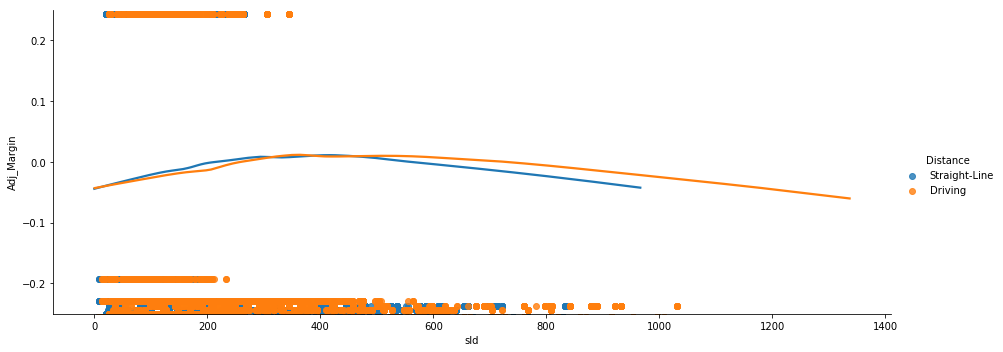

In [327]:
s = sns.lmplot(data = dataset, y= 'Adj_Margin', x = 'sld', hue='Distance', aspect=2.5, lowess=True)
axes = s.axes
axes[0,0].set_ylim(-0.25,0.25)

(-0.25, 0.25)

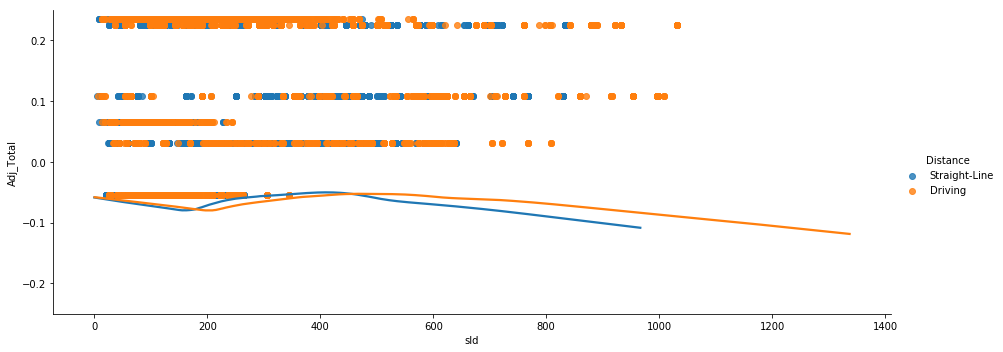

In [329]:
s = sns.lmplot(data = dataset, y= 'Adj_Total', x = 'sld', hue='Distance', aspect=2.5, lowess=True)
axes = s.axes
axes[0,0].set_ylim(-0.25,0.25)

In [349]:
w_data = prev_games[~prev_games.Temp.isna()]


In [350]:
w_data = w_data.loc[:,['Country', 'Adj_Total', 'Adj_Margin', 'Temp', 'DewPt', 'Humid', 'Wind', 'WindGust', 'Press', 'Precip', 'sld', 'drd', 'Condition']]
w_data.corr()

,Adj_Total,Adj_Margin,Temp,DewPt,Humid,Wind,WindGust,Press,Precip,sld,drd
Adj_Total,1.000000,0.139100,-0.008208,-0.005291,0.009659,-0.000100,0.011326,-0.002935,-0.002658,0.012800,0.011805
Adj_Margin,0.139100,1.000000,-0.006066,-0.001228,0.005397,0.010968,0.009405,0.003318,-0.001513,0.005472,0.004431
Temp,-0.008208,-0.006066,1.000000,0.731313,-0.193234,-0.017686,-0.002221,-0.002857,-0.001798,0.001619,0.001304
DewPt,-0.005291,-0.001228,0.731313,1.000000,0.109152,-0.039809,0.002468,-0.007219,0.001085,0.000212,0.000353
Humid,0.009659,0.005397,-0.193234,0.109152,1.000000,0.014656,0.006580,-0.007075,0.005019,0.006348,0.006635
Wind,-0.000100,0.010968,-0.017686,-0.039809,0.014656,1.000000,0.380504,-0.069827,0.008489,0.007554,0.006867
WindGust,0.011326,0.009405,-0.002221,0.002468,0.006580,0.380504,1.000000,-0.055064,0.028677,-0.001135,-0.002021
Press,-0.002935,0.003318,-0.002857,-0.007219,-0.007075,-0.069827,-0.055064,1.000000,-0.000952,-0.011565,-0.011881
Precip,-0.002658,-0.001513,-0.001798,0.001085,0.005019,0.008489,0.028677,-0.000952,1.000000,0.004193,0.002997
sld,0.012800,0.005472,0.001619,0.000212,0.006348,0.007554,-0.001135,-0.011565,0.004193,1.000000,0.993013


(-0.25, 0.25)

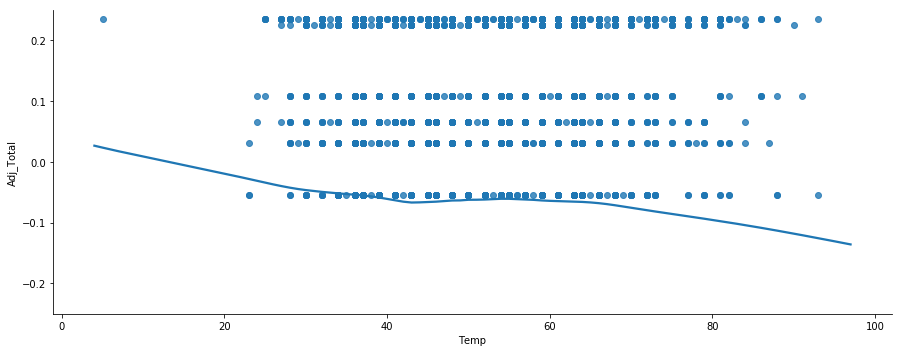

In [333]:
s = sns.lmplot(data = w_data, y= 'Adj_Total', x = 'Temp', aspect=2.5, lowess=True)
axes = s.axes
axes[0,0].set_ylim(-0.25, 0.25)

(-0.25, 0.25)

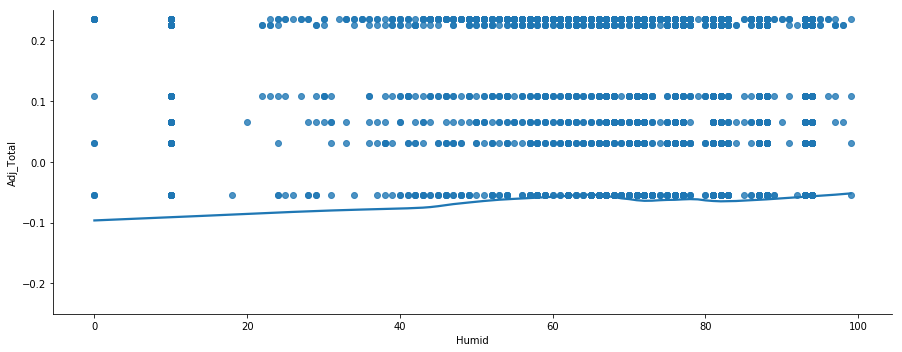

In [335]:
s = sns.lmplot(data = w_data, y= 'Adj_Total', x = 'Humid', aspect=2.5, lowess=True)
axes = s.axes
axes[0,0].set_ylim(-0.25,0.25)

(-0.25, 0.25)

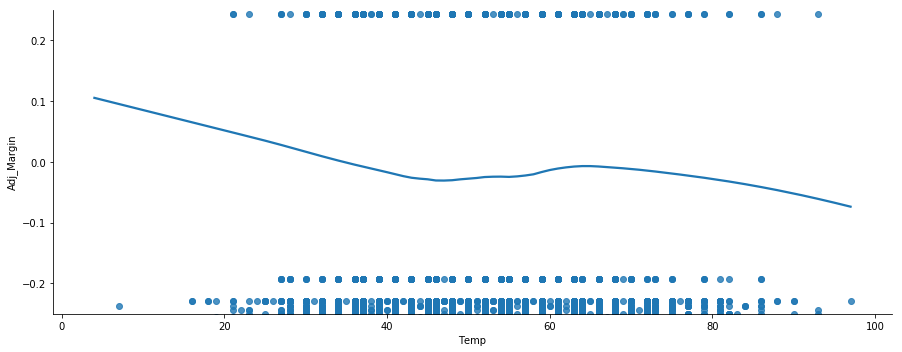

In [336]:
s = sns.lmplot(data = w_data, y= 'Adj_Margin', x = 'Temp', aspect=2.5, lowess=True)
axes = s.axes
axes[0,0].set_ylim(-0.25,0.25)

(-0.25, 0.25)

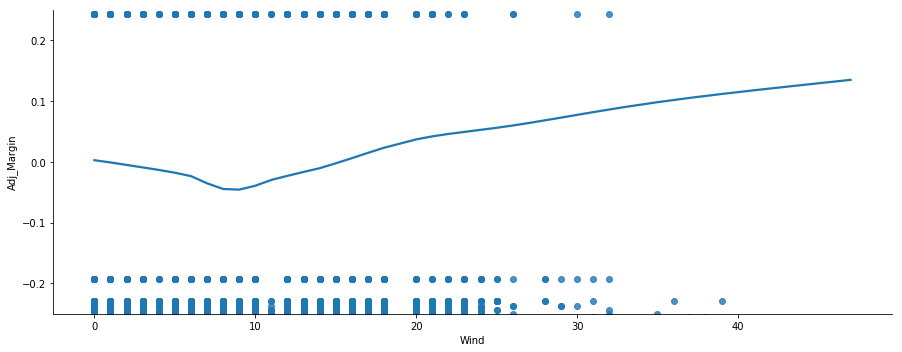

In [337]:
s = sns.lmplot(data = w_data, y= 'Adj_Margin', x = 'Wind', aspect=2.5, lowess=True)
axes = s.axes
axes[0,0].set_ylim(-0.25, 0.25)

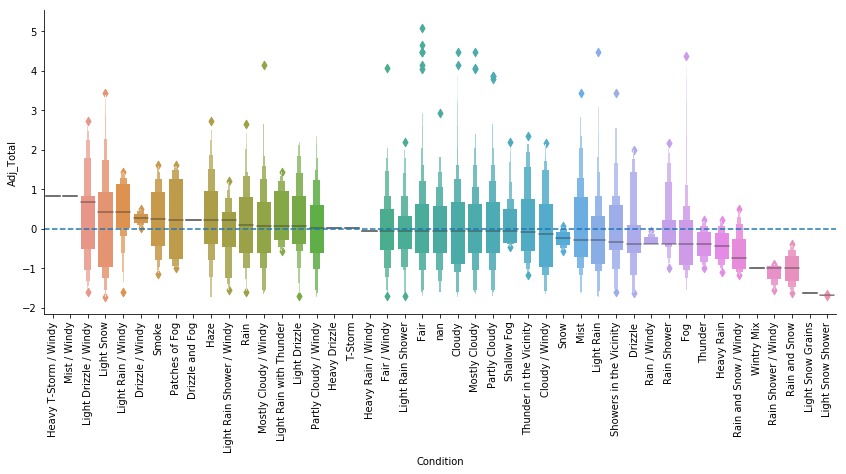

In [378]:
# Find the order
my_order = w_data.groupby('Condition')['Adj_Total'].median().sort_values(ascending=False).index
g = sns.catplot(data = w_data, x='Condition', y='Adj_Total', aspect=2.5, kind='boxen', order=my_order)
g.set_xticklabels(rotation=90)
ax1 = g.axes[0][0]
ax1.axhline(0, ls='--')

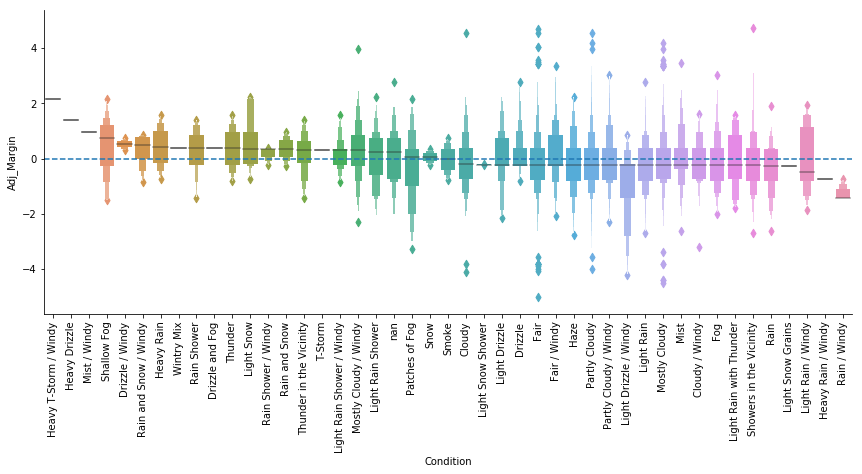

In [379]:
my_order = w_data.groupby('Condition')['Adj_Margin'].median().sort_values(ascending=False).index
g = sns.catplot(data = w_data, x='Condition', y='Adj_Margin', aspect=2.5, kind='boxen', order=my_order)
g.set_xticklabels(rotation=90)
ax1 = g.axes[0][0]
ax1.axhline(0, ls='--')